# 2 ways to process signal
* Based on exact tags count using fragment size UNIQUE_BAM -> PILEUP_BED -> TAGS -> intersect with given regions bed and compute intersection
* Based on bigwigs UNIQUE_BAM -> BIGWIG -> bigWigAverageOverBed

## Interesting LOCI
All merged `/mnt/stripe/bio/raw-data/aging/loci_of_interest/`

# Process signals, normalize, build PCA
```
export WASHU_ROOT="/mnt/stripe/washu"
export PYTHONPATH="$WASHU_ROOT:$PYTHONPATH"
export WASHU_PARALLELISM=20
DIR=$(pwd); for M in H3K27ac H3K27me3 H3K36me3 H3K4me1 H3K4me3; do     
    echo "Processing $M";      
    PEAKS=$(ls /mnt/stripe/bio/raw-data/aging/loci_of_interest/weak_consensus/${M}_span_weak_consensus.bed);     
    echo "Peaks $PEAKS";     
    BEDS=$(find /mnt/stripe/bio/raw-data/aging/loci_of_interest/ -name "*.bed" | grep -vE 'repeat|pathway');     
    BEDSL=$(echo "$BEDS" | wc -l);     
    I=1;     
    for BED in ${BEDS[@]}; do          
        echo "$I/$BEDSL"; 
        I=$(($I+1));         
        bash /home/user/work/shpynov/washu/downstream/signals/signals.sh  $DIR/$M 150 $BED /mnt/stripe/bio/genomes/hg19/hg19.chrom.sizes $PEAKS;     
    done; 
done 2>&1 | tee log.txt

# Create report
bash /mnt/stripe/washu/downstream/signals/signals_report.sh $(pwd) > $(pwd)/report.tsv
```
# All histone modifications processing
```
# Union all the weak  peaks
bash /mnt/stripe/washu/bed/union.sh /mnt/stripe/bio/raw-data/aging/loci_of_interest/weak_consensus/*_span_weak_consensus.bed > weaks_consensus_union.bed
Ensure that you have required signals@regions for aging data and encode data.
```

In [2]:
%run /mnt/stripe/washu/downstream/signals/signals_visualize.py

ARGUMENTS:  <data.tsv>
<data.tsv> - processed signal file to visualize and build PCAARGS: 


/home/user/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


SystemExit: 1

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import re
import pandas as pd

import matplotlib.pyplot as plt  # nopep8


# Explicitly setup style
plt.style.use('seaborn-darkgrid')

COLORS_MAP = {"H3K27ac" : "red", 
              "H3K27me3" : "blueviolet", 
              "H3K36me3": "blue", 
              "H3K4me1" : "gold", 
              "H3K4me3": "green"}
GROUPS = {}
for k, v in COLORS_MAP.items():
    GROUPS[k] = Group(k, v)
    
def find_group(x):
    for k, v in GROUPS.items():
        if re.match('.*{}.*'.format(k), x):
            return v
    return UNKNOWN

REGIONS=["span_weak_consensus_union", "hg19_100000", "hg19_1000"]
NORMALIZATIONS=['raw', 'rawz', 'rpm', 'rpkm', 'fripm', "manorm",
                'diffbind_tmm_minus_full', 'diffbind_tmm_reads_full_cpm', 'diffbind_tmm_reads_effective_cpm']


def load_dfs(region, normalization):
    AGING_PATH='/mnt/stripe/bio/experiments/signal_experiment'
    ENCODE_PATH='/mnt/stripe/bio/experiments/signal_experiment_encode'
    print('Processing', normalization, 'at', region)
    dfs = []
    for hist_mod in GROUPS.keys():
        path = '{0}/{1}/150/{2}/{2}_{3}.tsv'.format(AGING_PATH, hist_mod, region, normalization)
        try:
            df = pd.read_csv(path, sep='\t').drop(['chr', 'start', 'end'], axis=1)
            df = df[[c for c in df.columns.values if not is_input(c)]]
            dfs.append(df)
        except:
            print("Failed to load", path)

    for hist_mod in GROUPS.keys():
        path = '{0}/{1}/150/{2}/{2}_{3}.tsv'.format(ENCODE_PATH, hist_mod, region, normalization)
        try:
            df = pd.read_csv(path, sep='\t').drop(['chr', 'start', 'end'], axis=1)
            df = df[[c for c in df.columns.values if not is_input(c)]]
            dfs.append(df)
        except:
            print("Failed to load", path)
    return dfs

Processing raw at span_weak_consensus_union


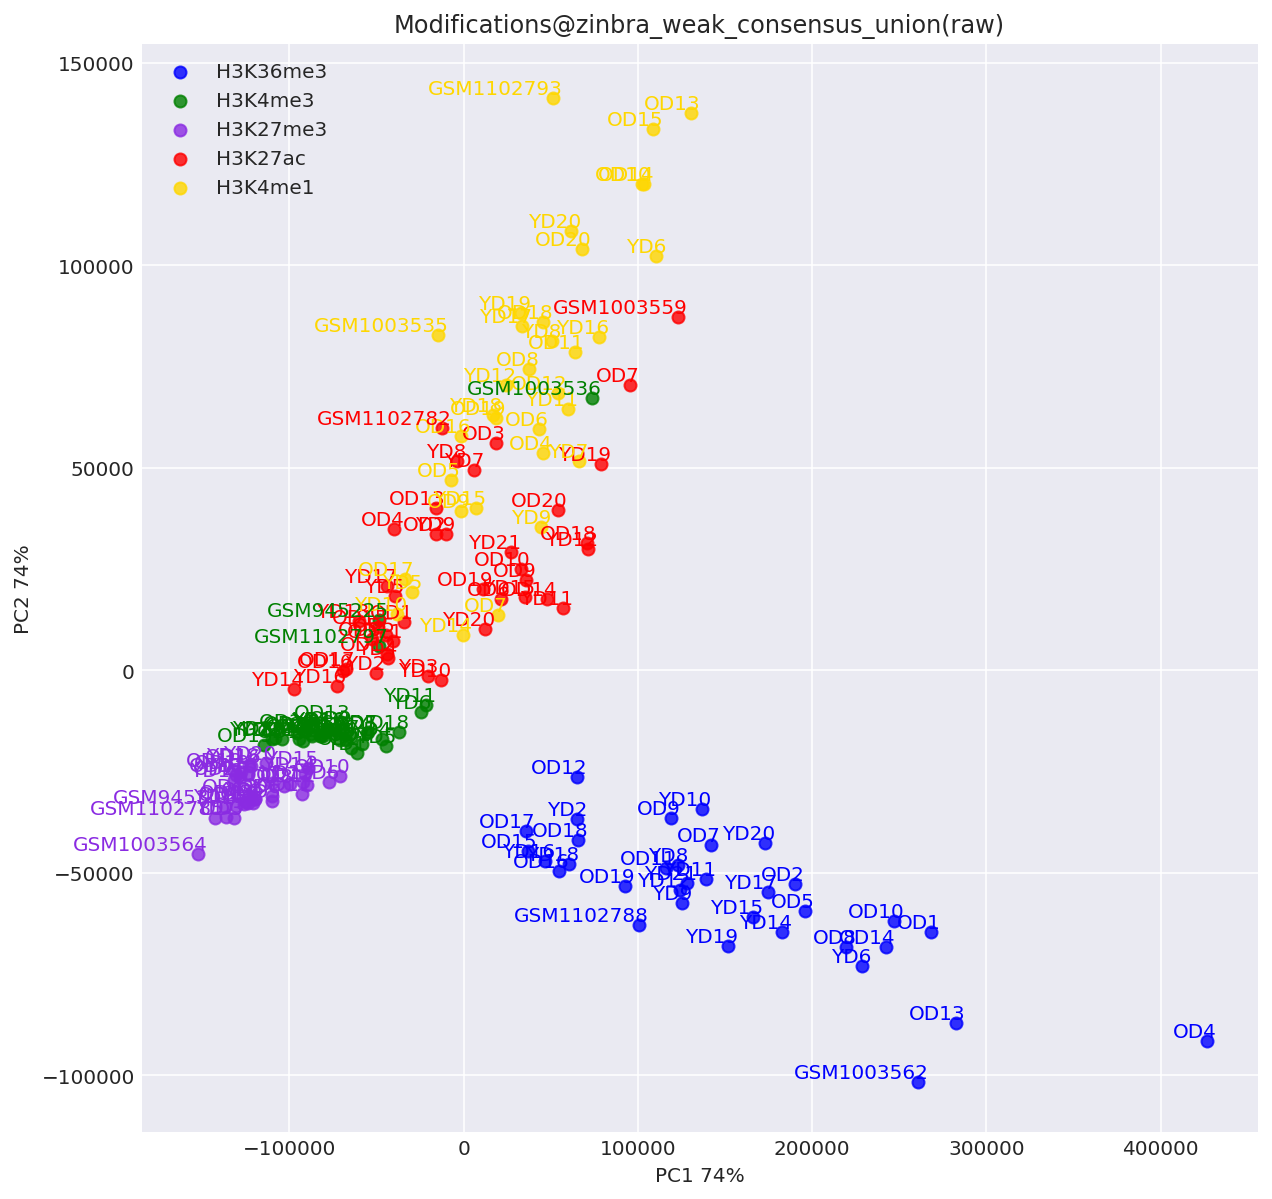

Processing rawz at span_weak_consensus_union


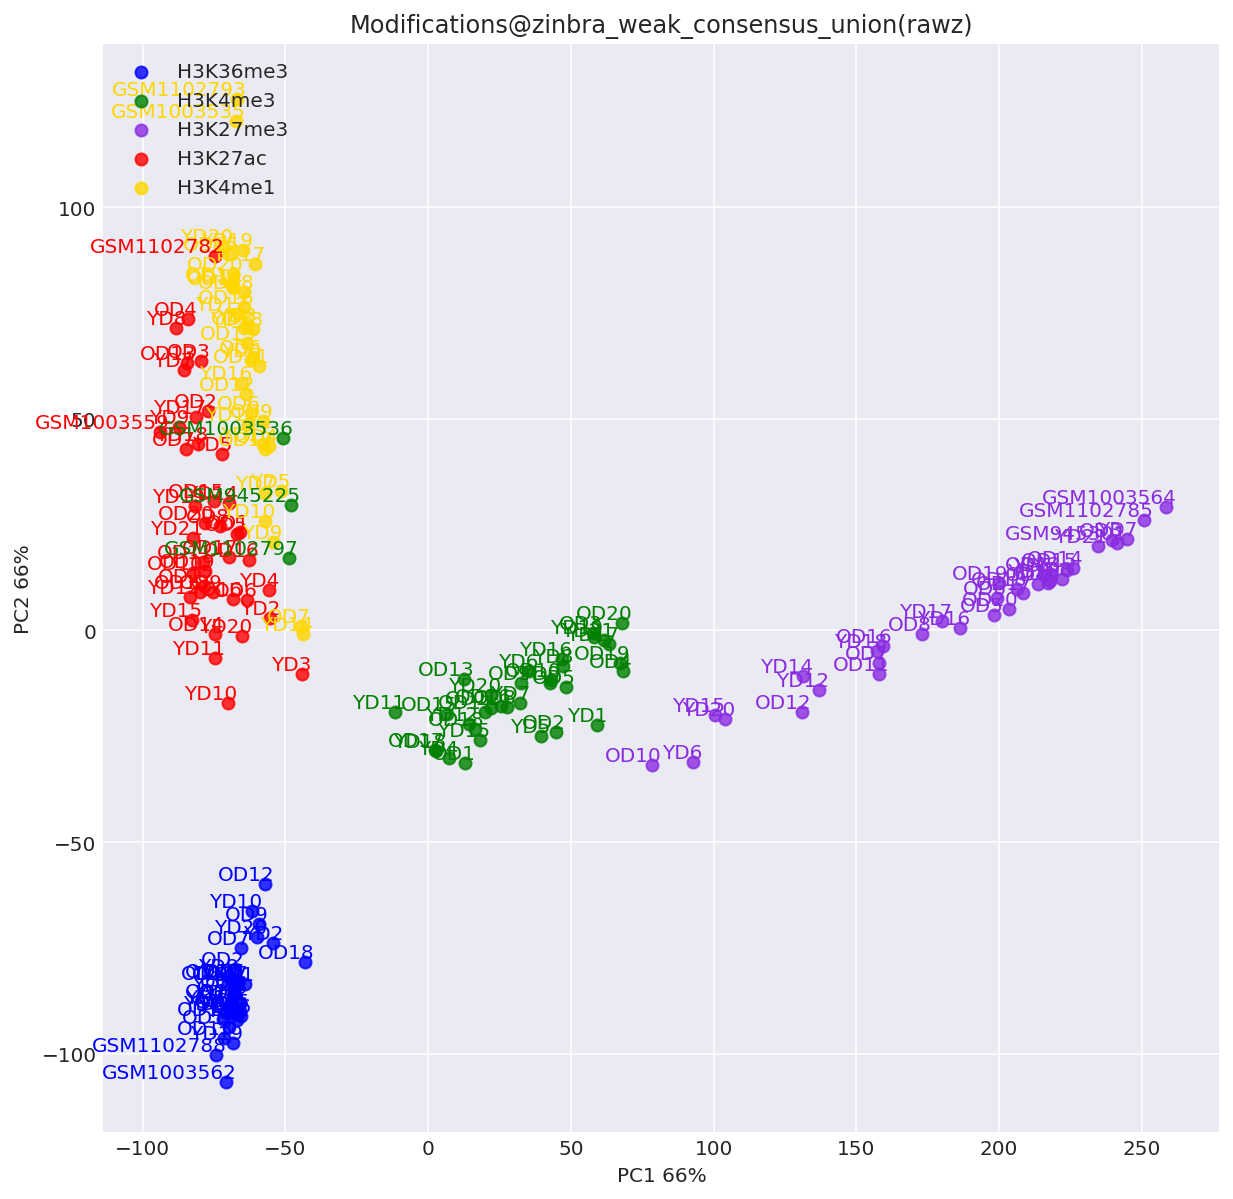

Processing rpm at span_weak_consensus_union


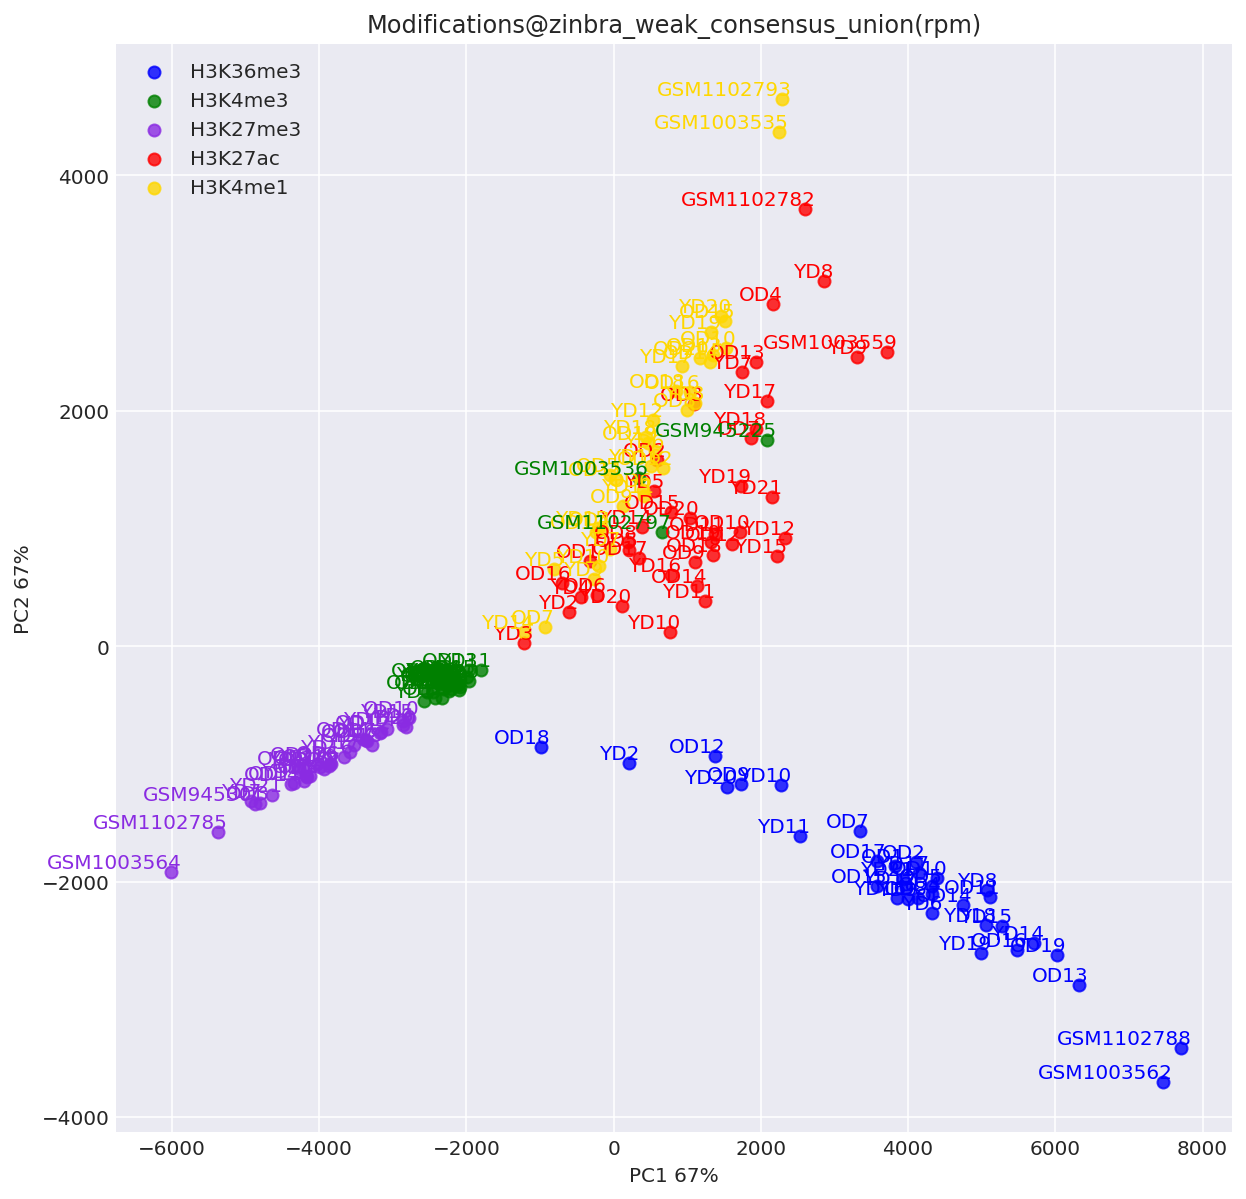

Processing rpkm at span_weak_consensus_union


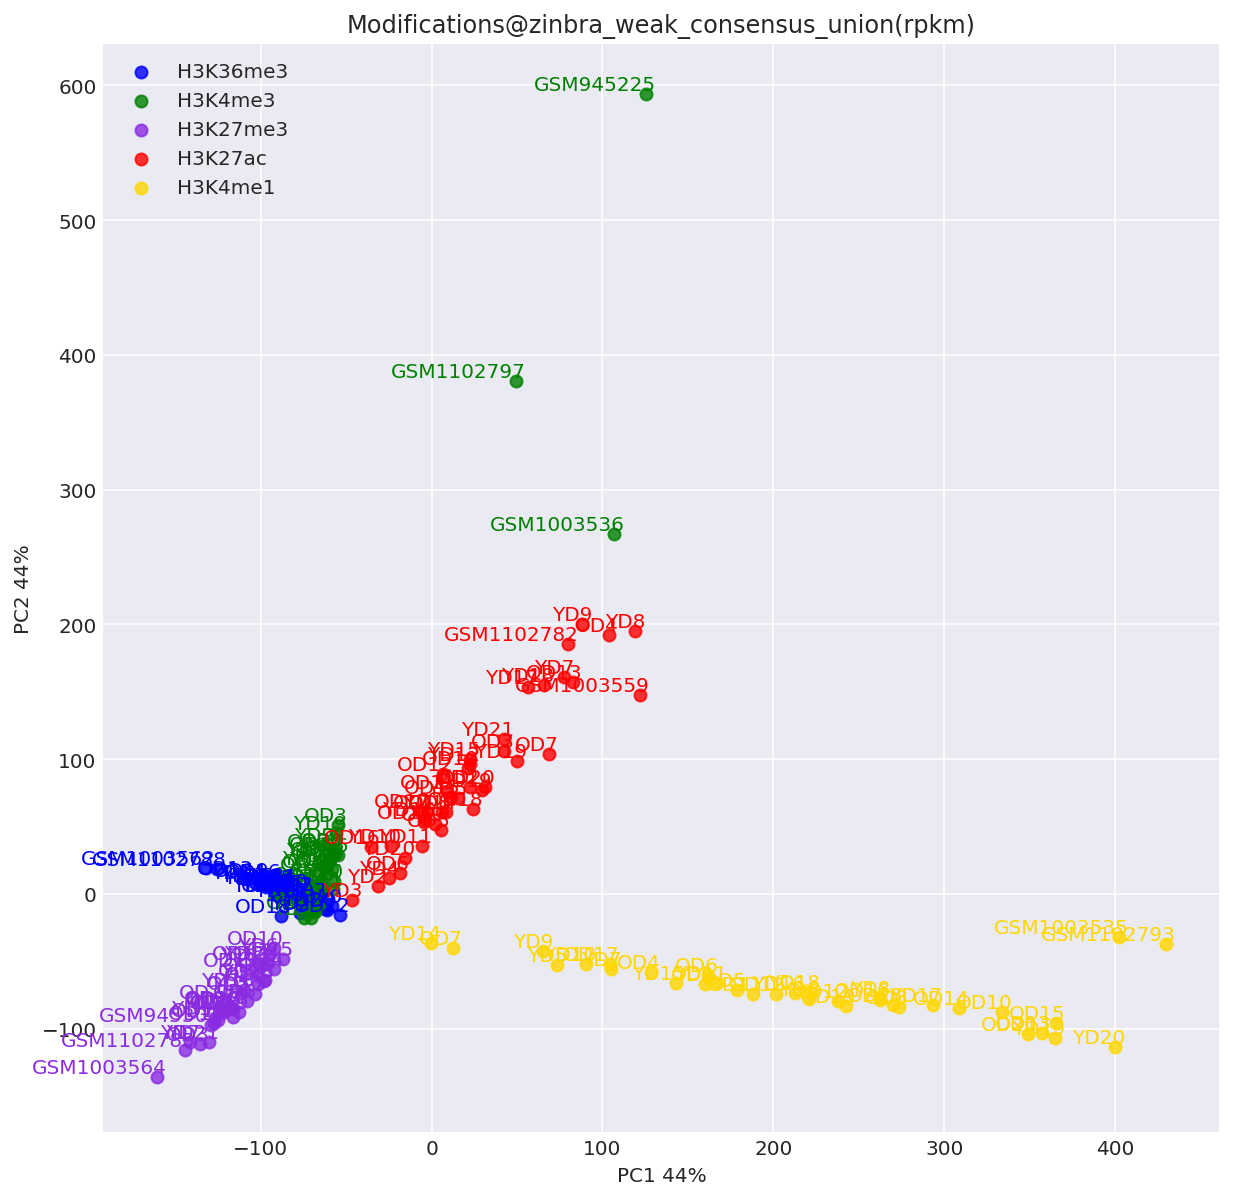

Processing fripm at span_weak_consensus_union


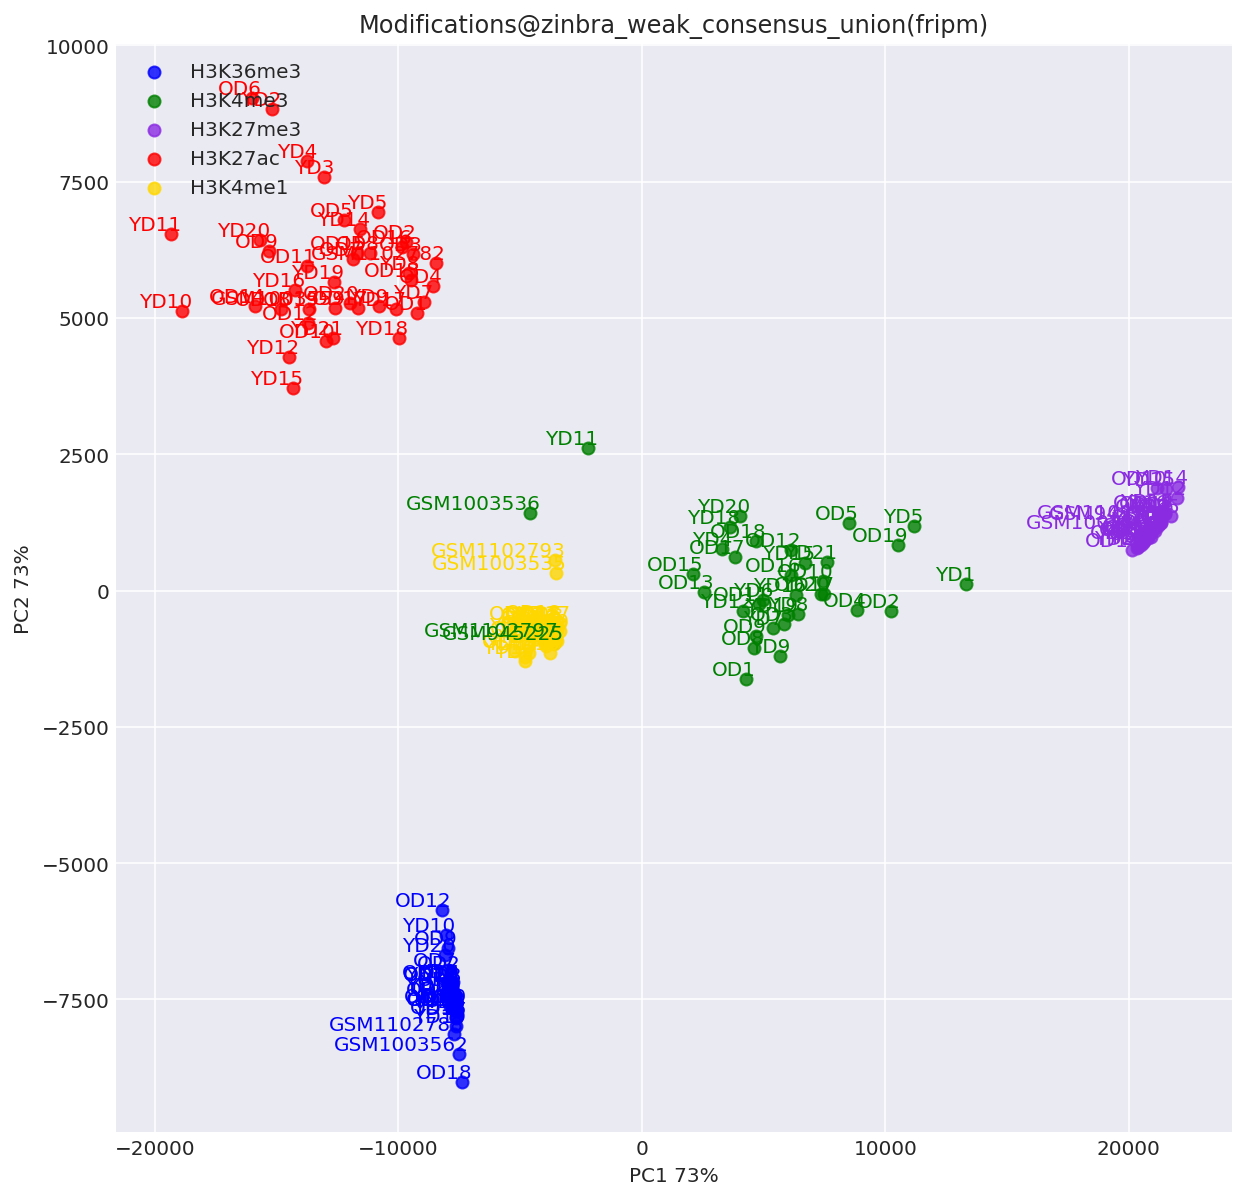

Processing manorm at span_weak_consensus_union


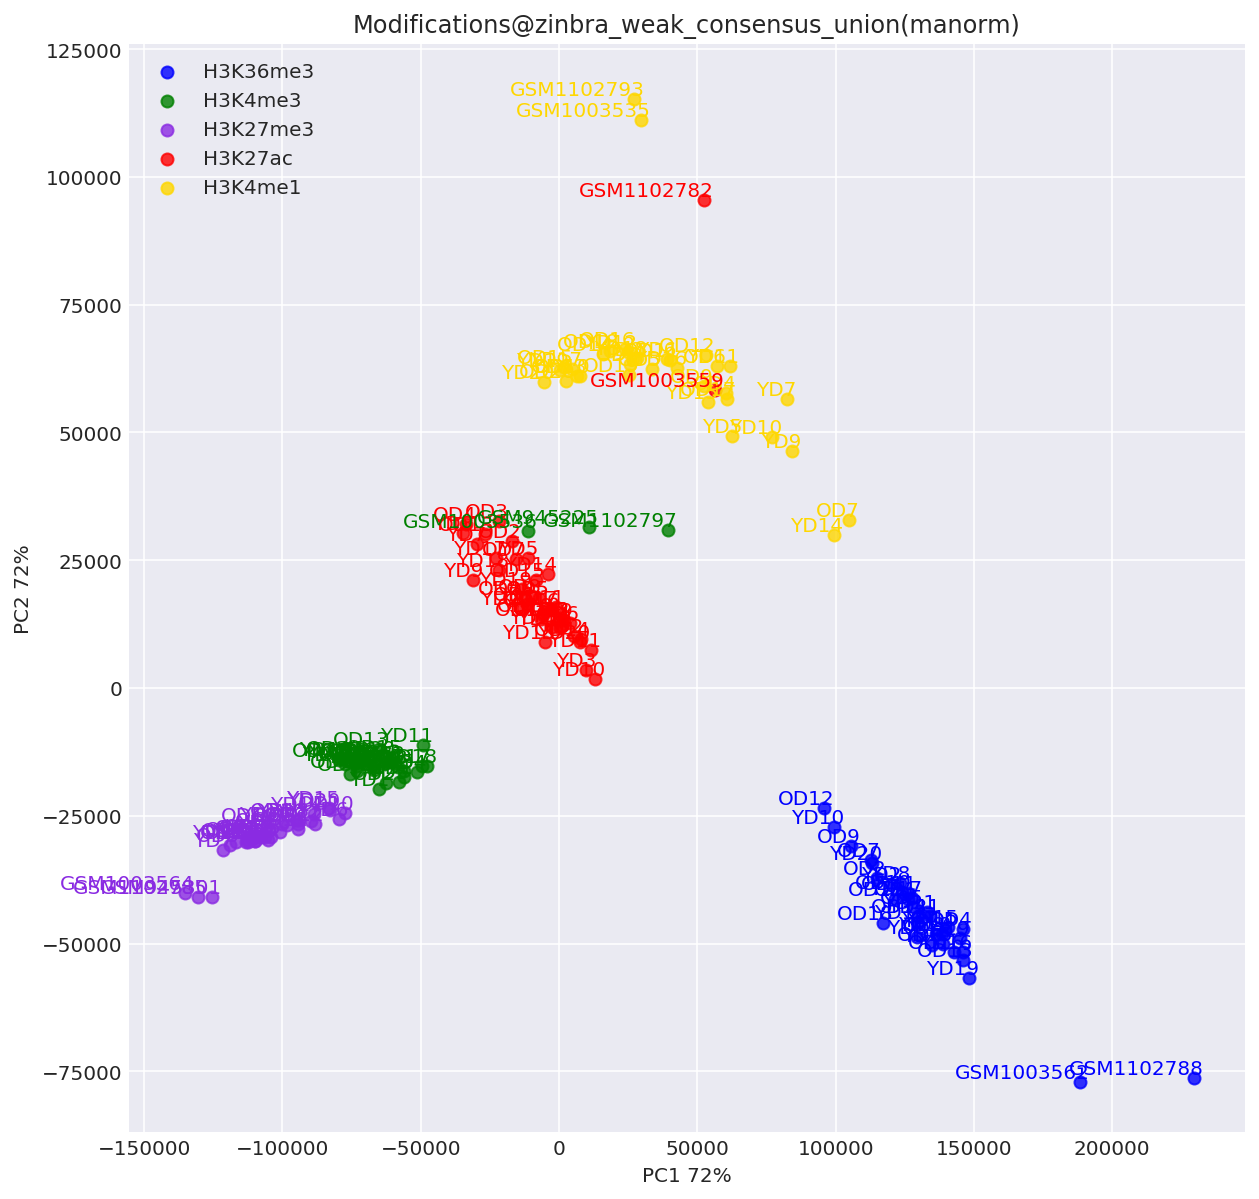

Processing diffbind_tmm_minus_full at span_weak_consensus_union


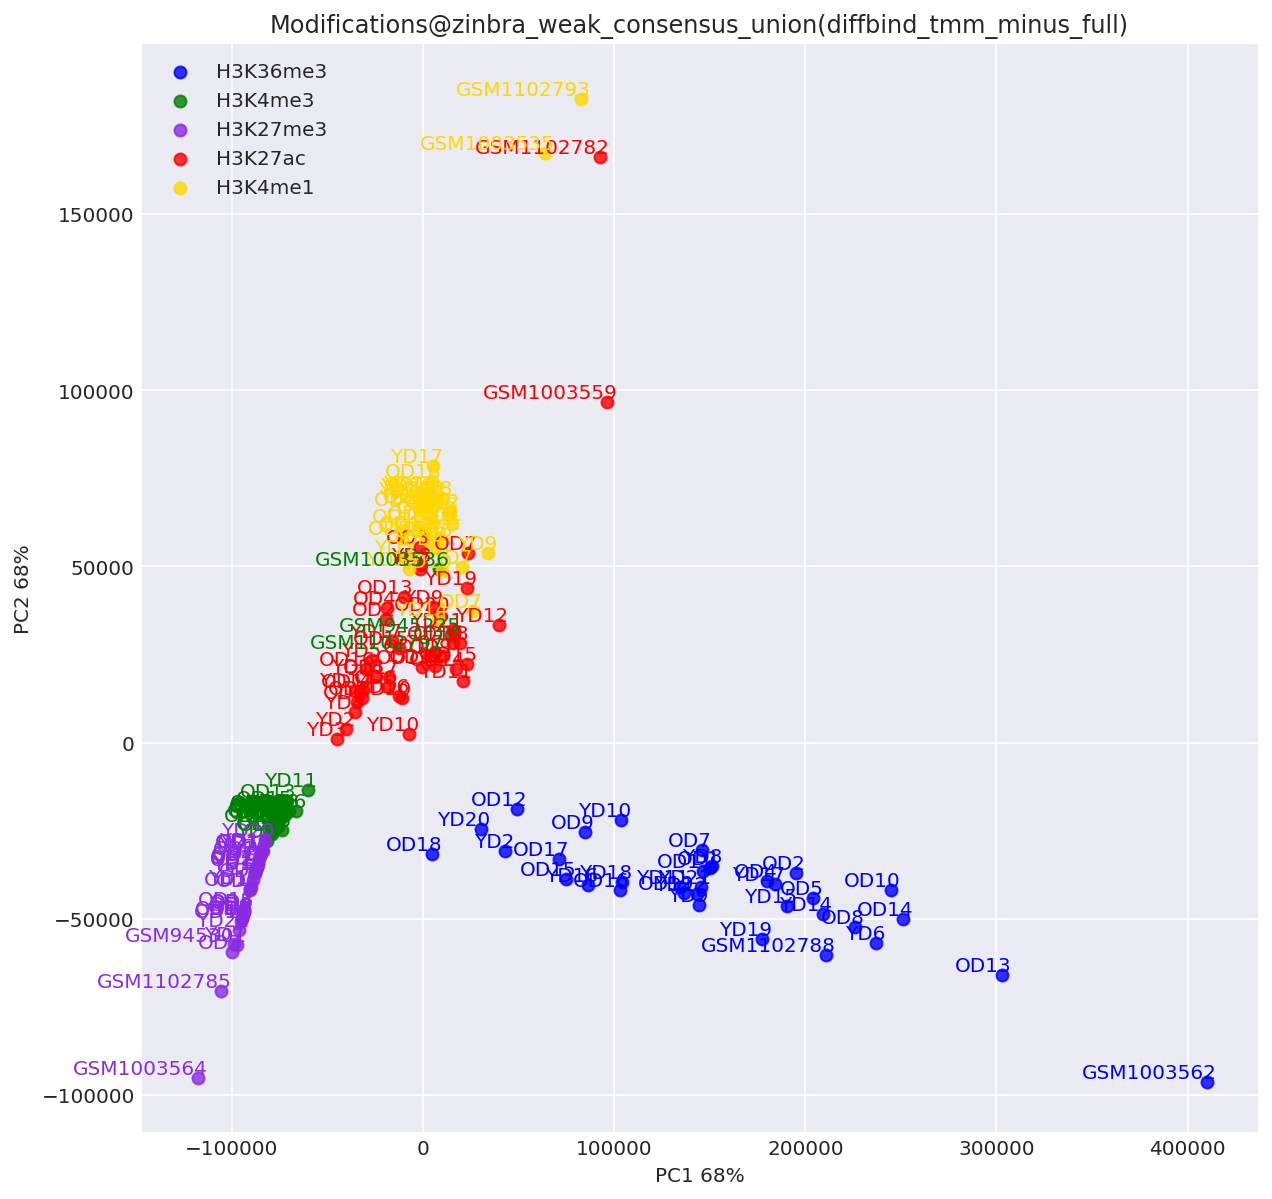

Processing diffbind_tmm_reads_full_cpm at span_weak_consensus_union


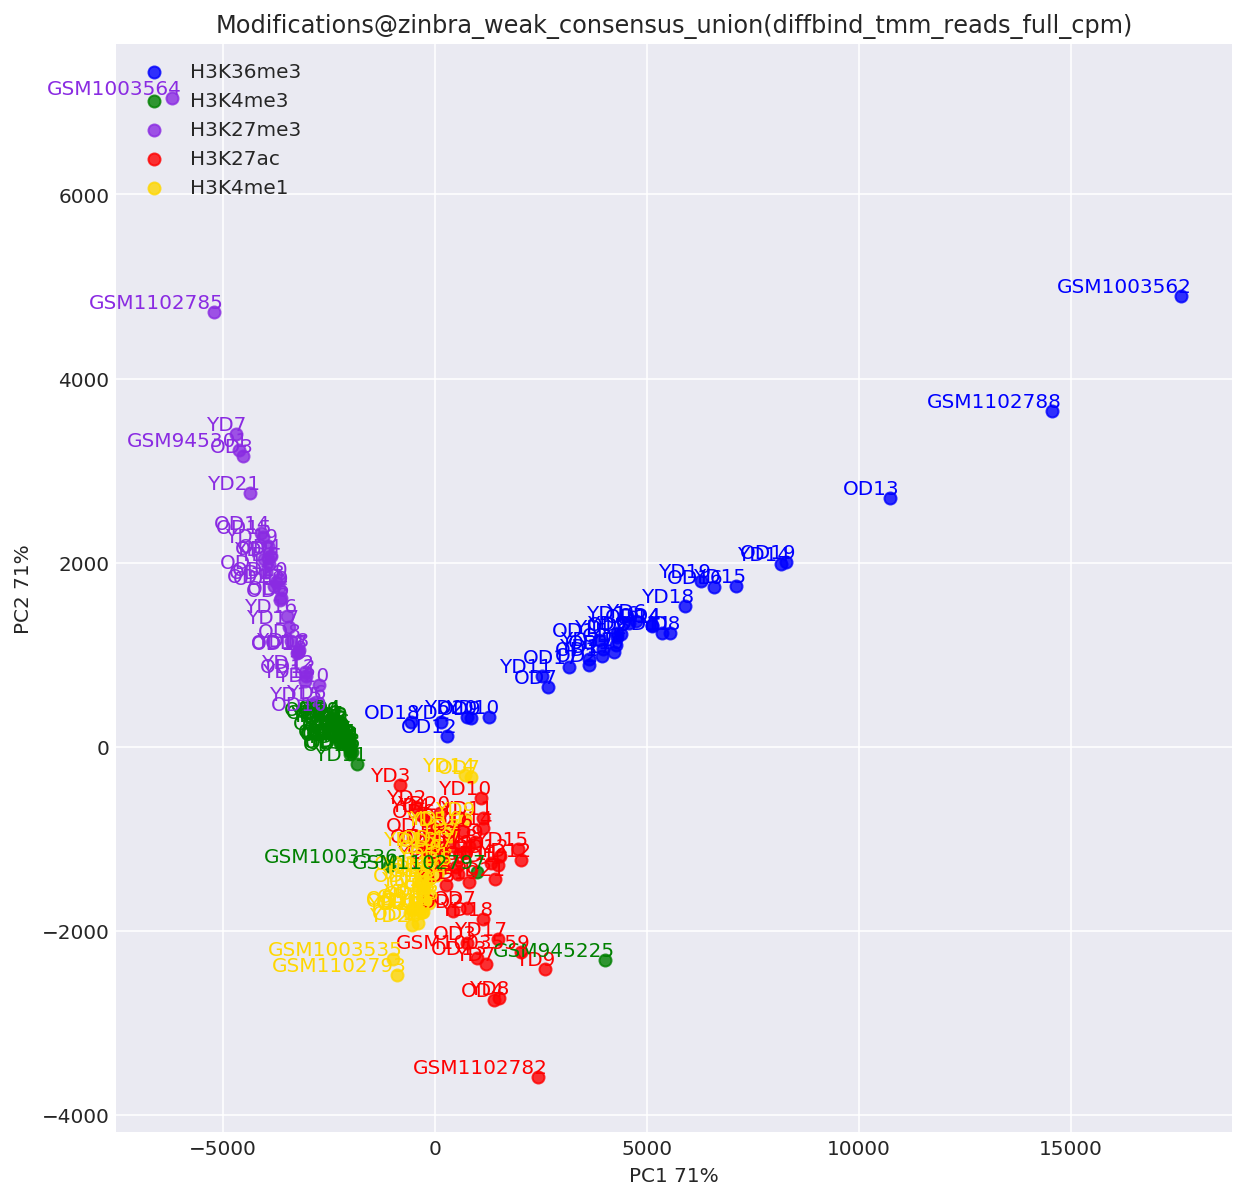

Processing diffbind_tmm_reads_effective_cpm at span_weak_consensus_union


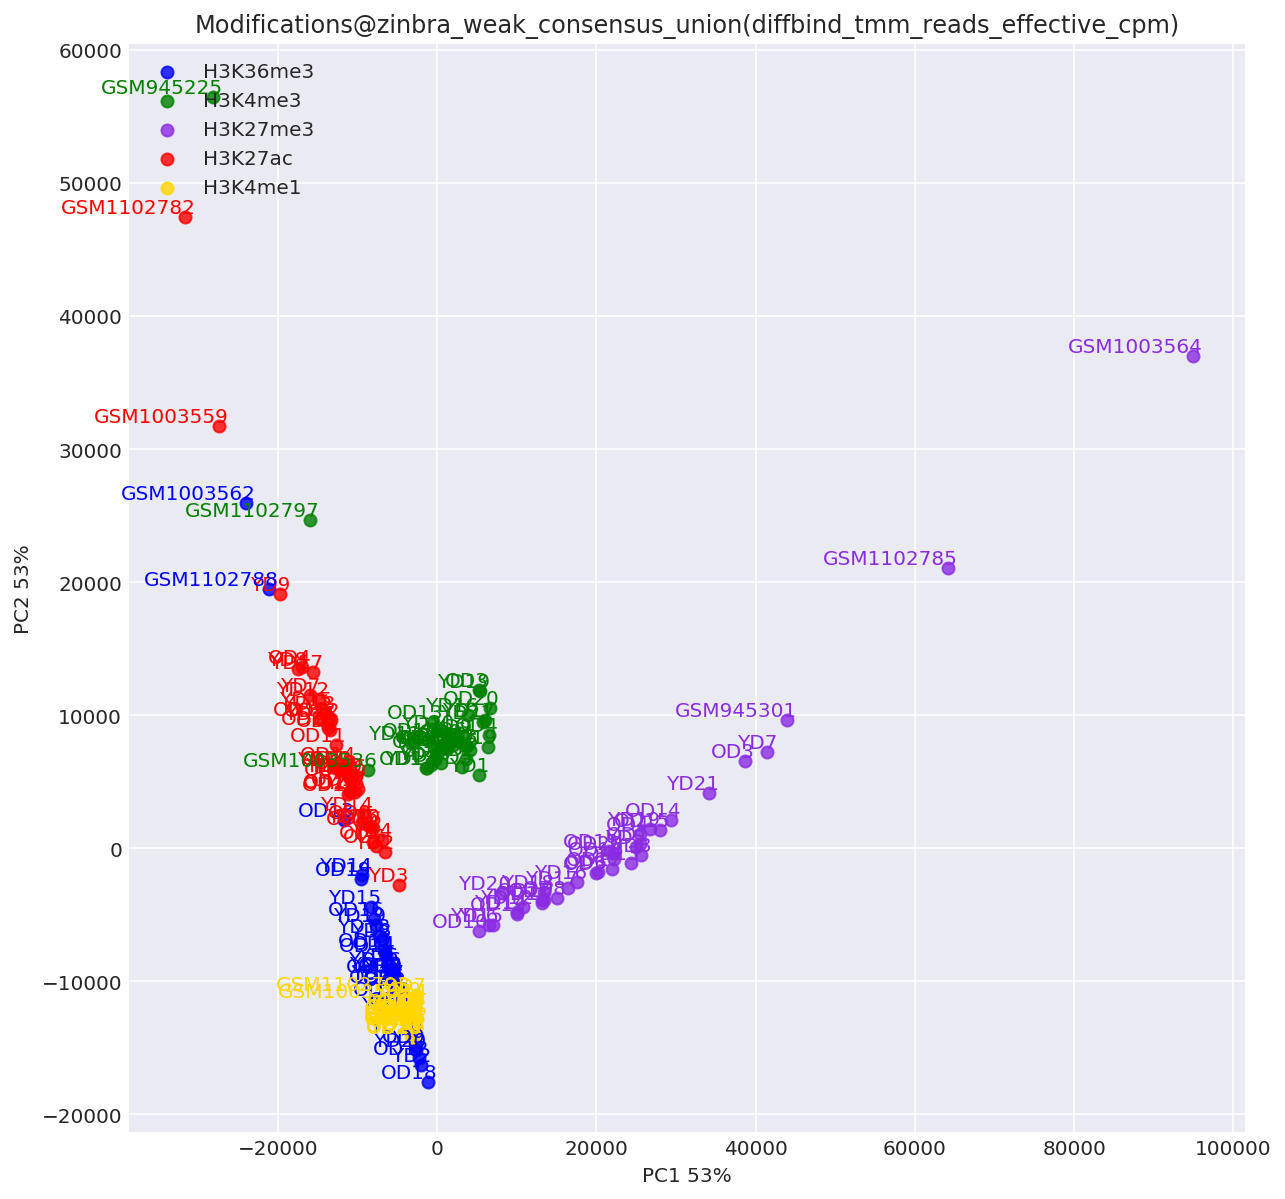

Processing raw at hg19_100000


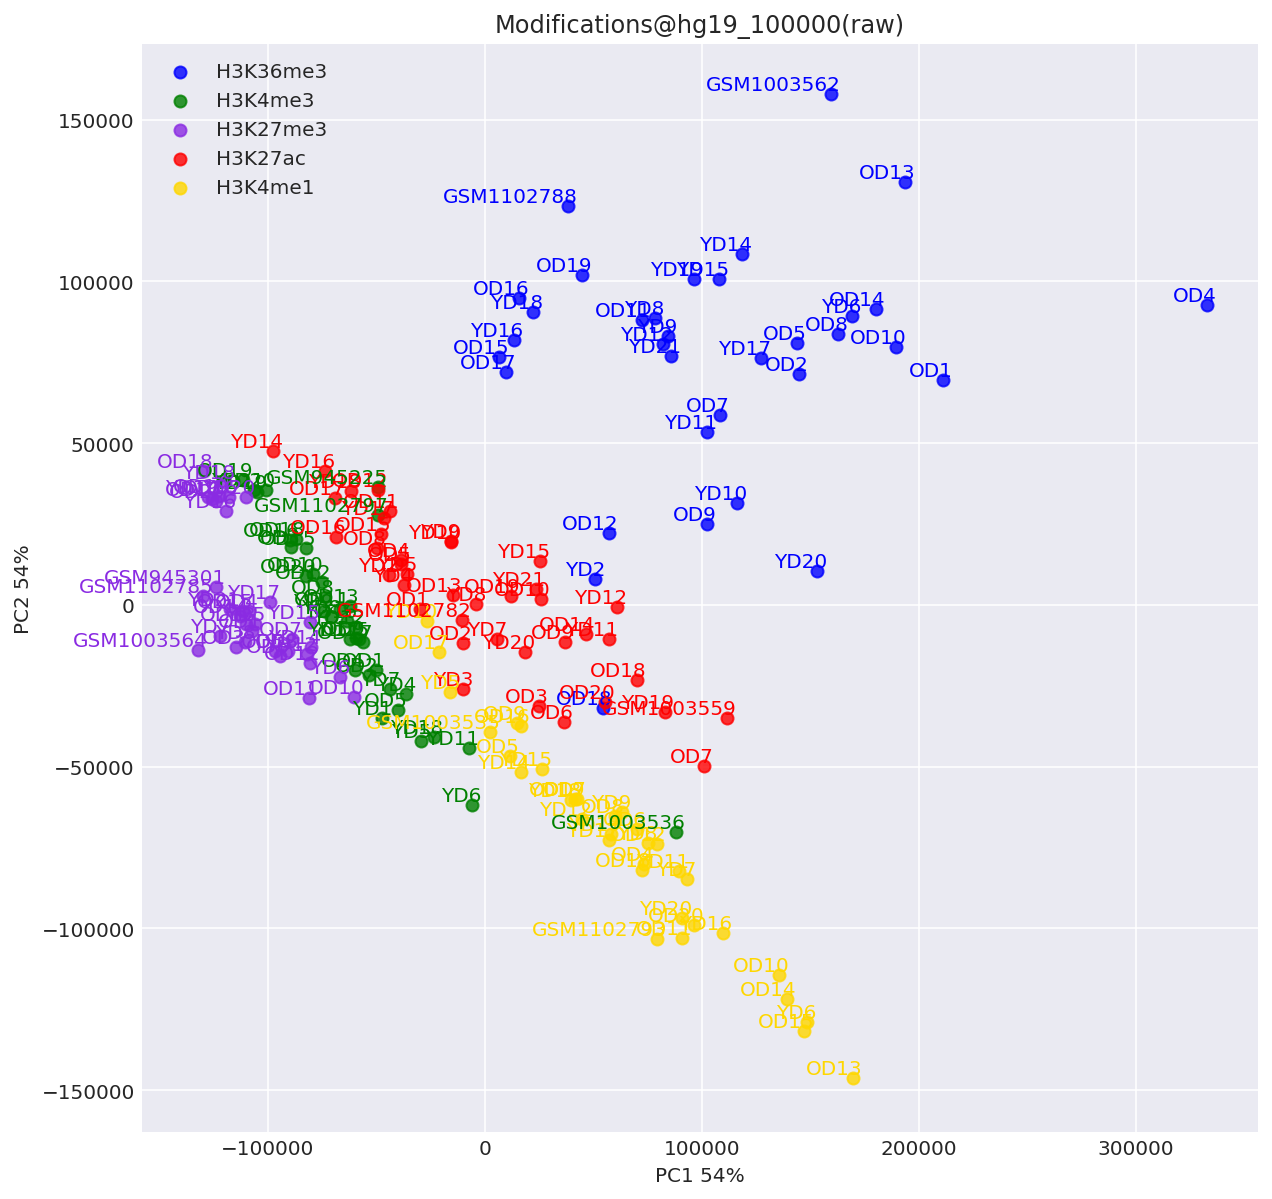

Processing rawz at hg19_100000


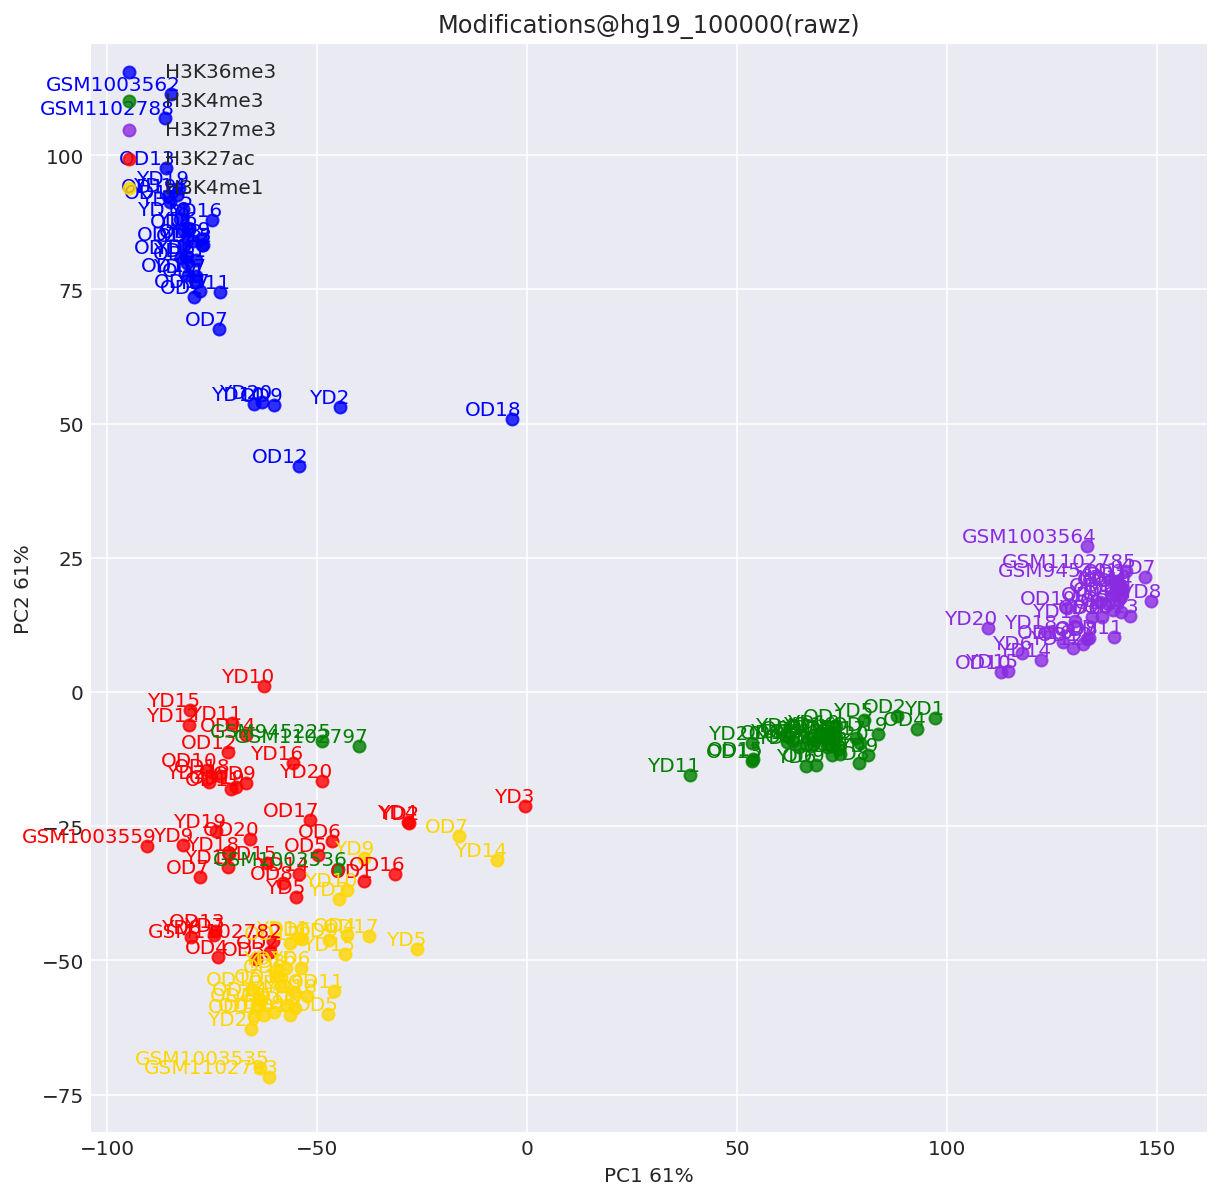

Processing rpm at hg19_100000


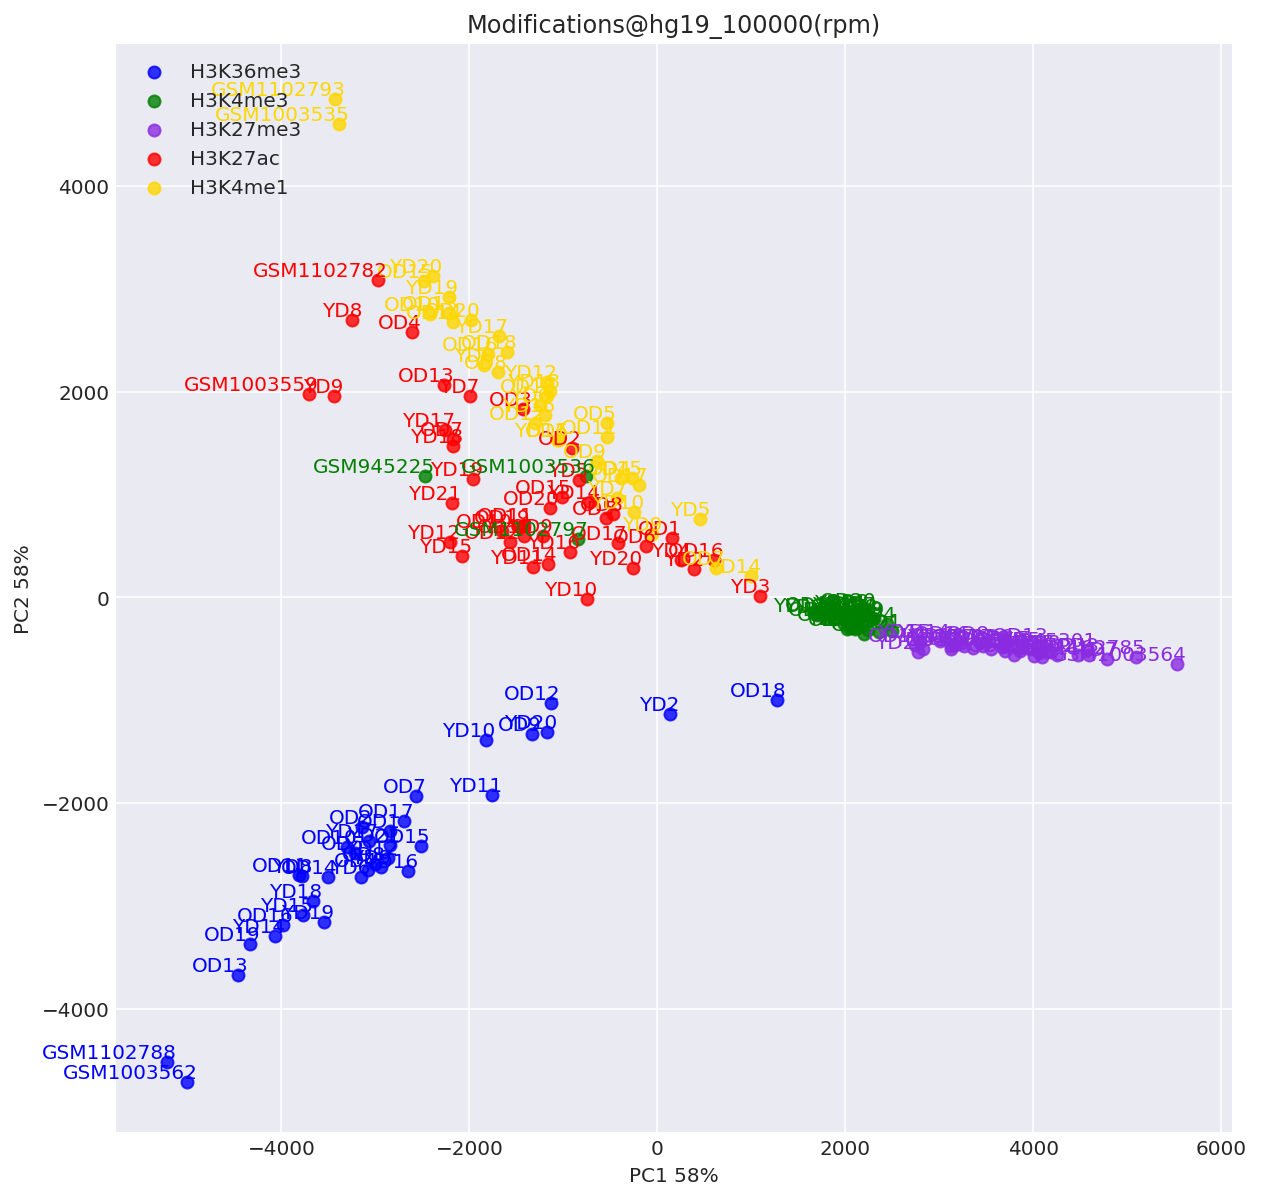

Processing rpkm at hg19_100000


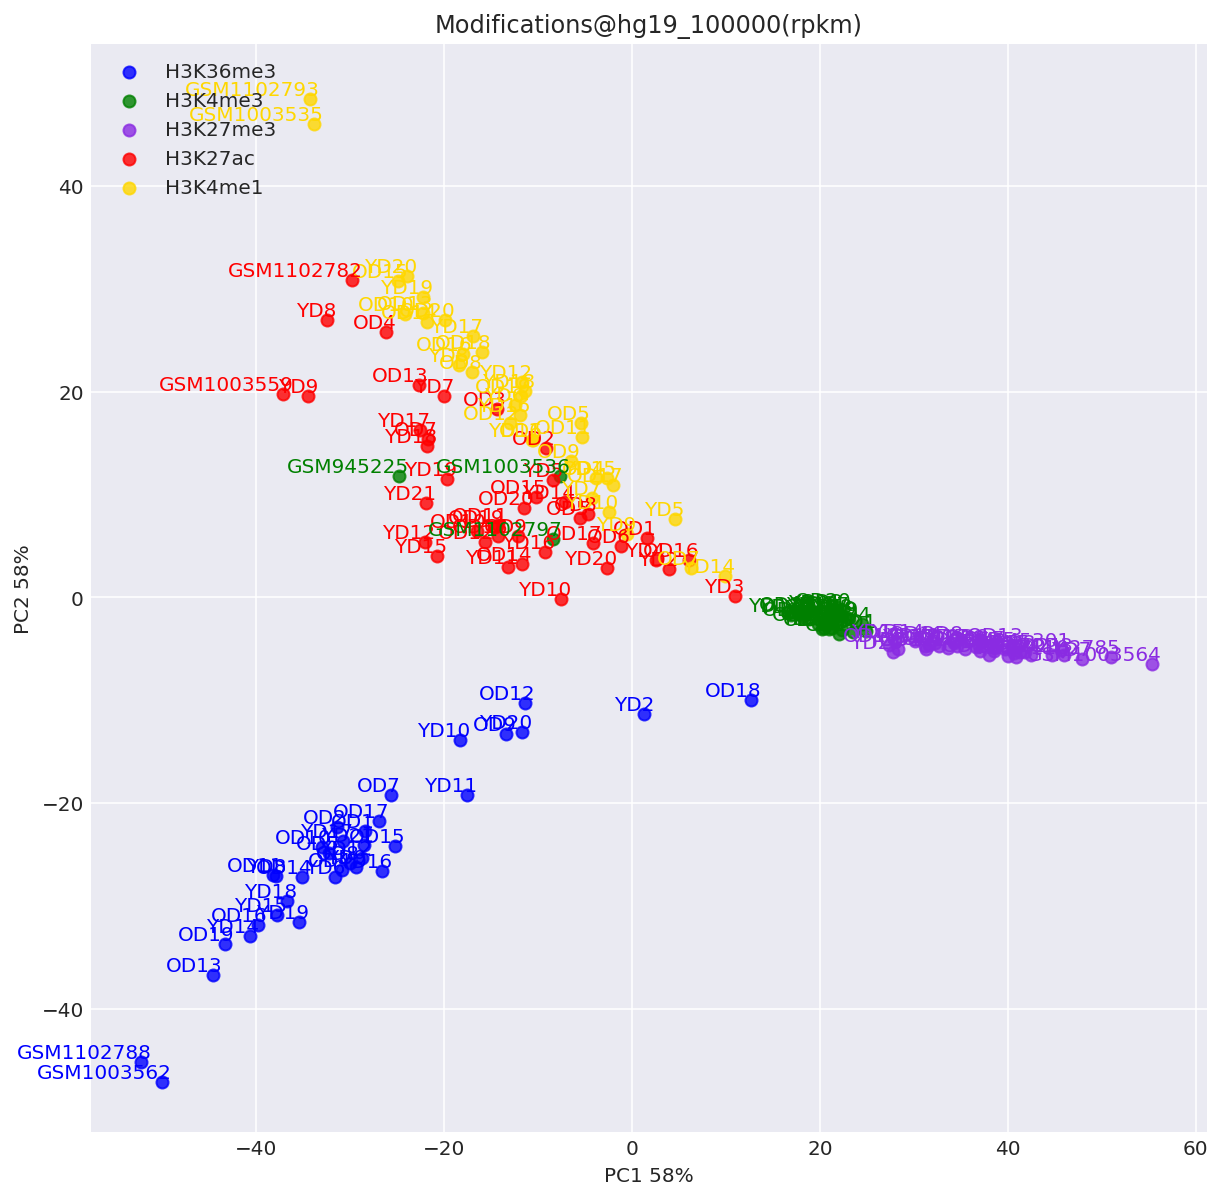

Processing fripm at hg19_100000


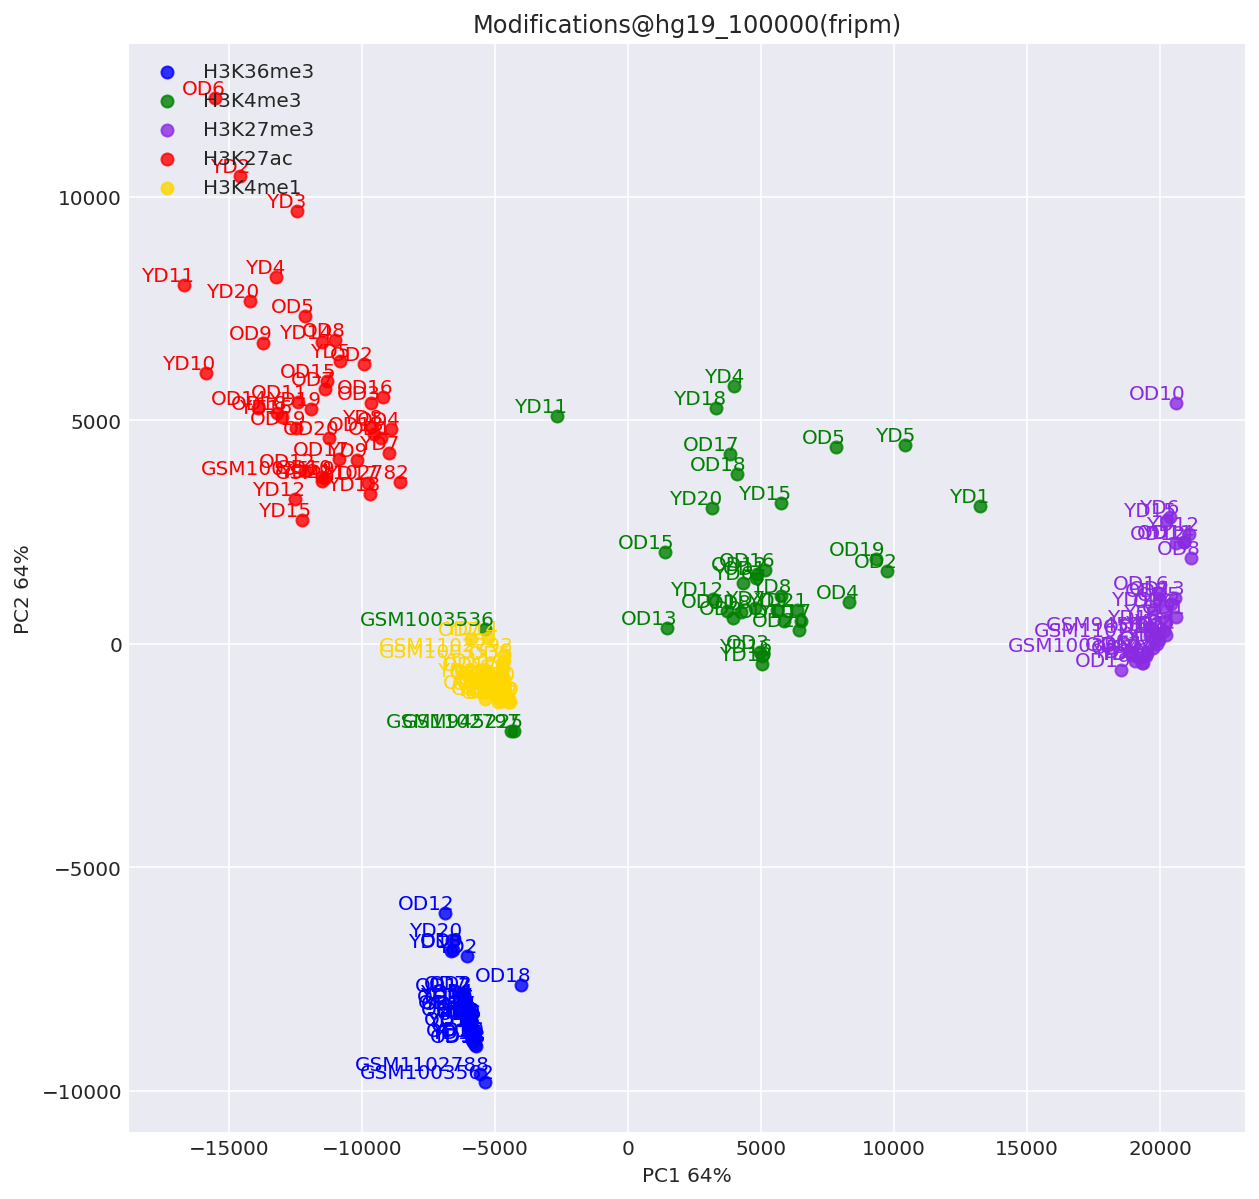

Processing manorm at hg19_100000


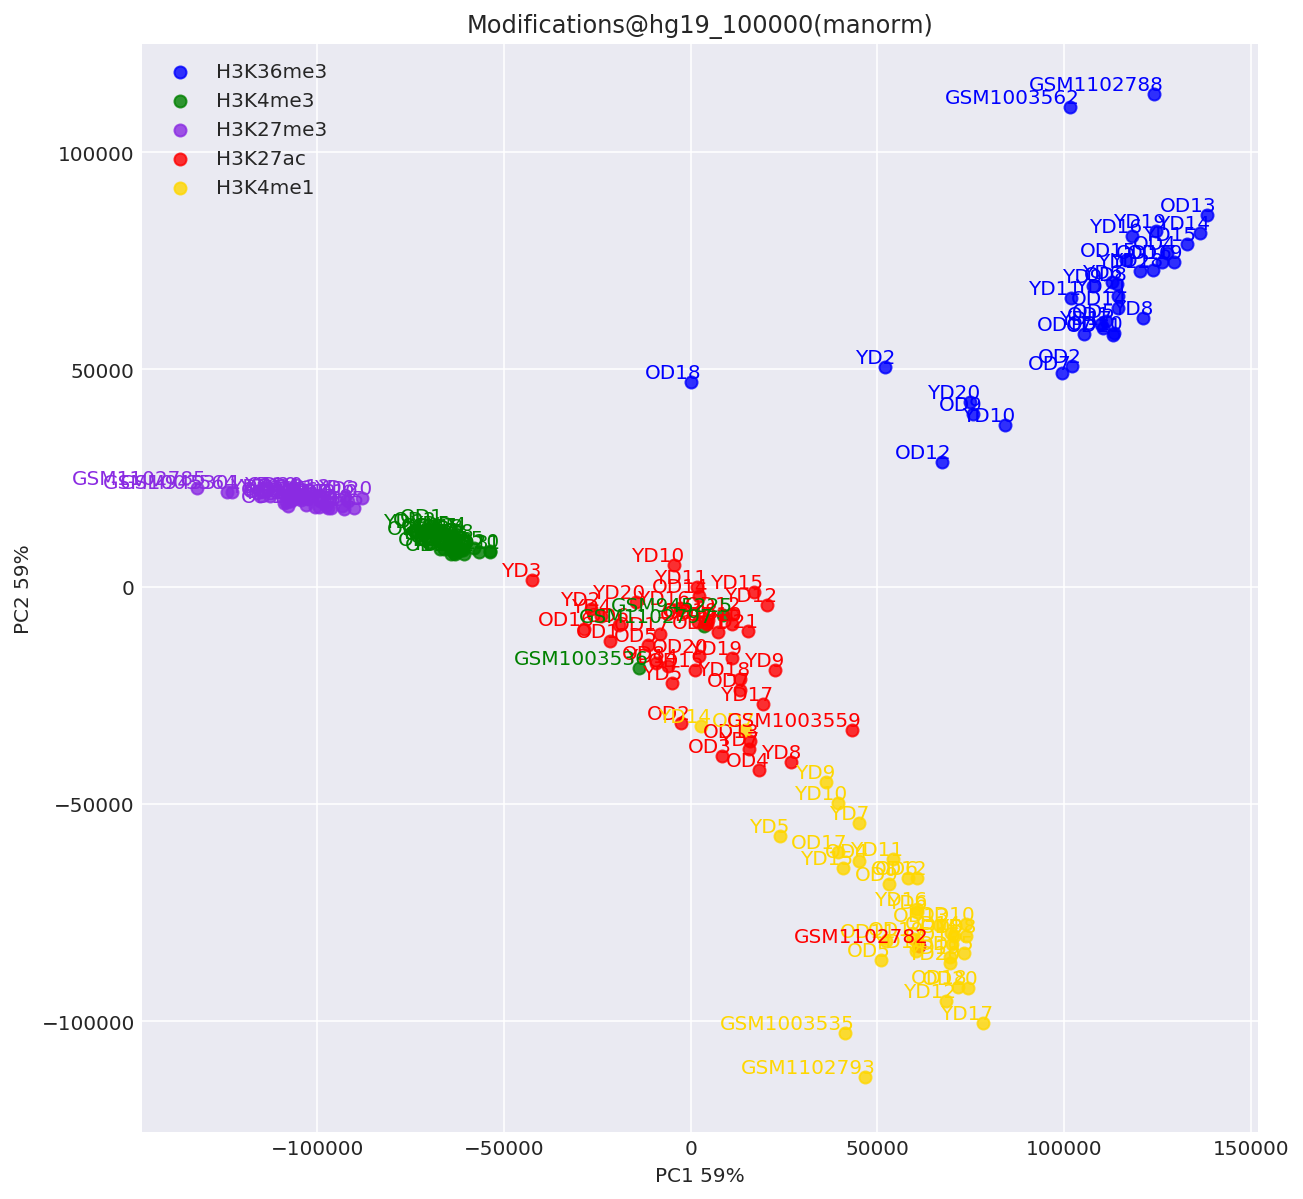

Processing diffbind_tmm_minus_full at hg19_100000


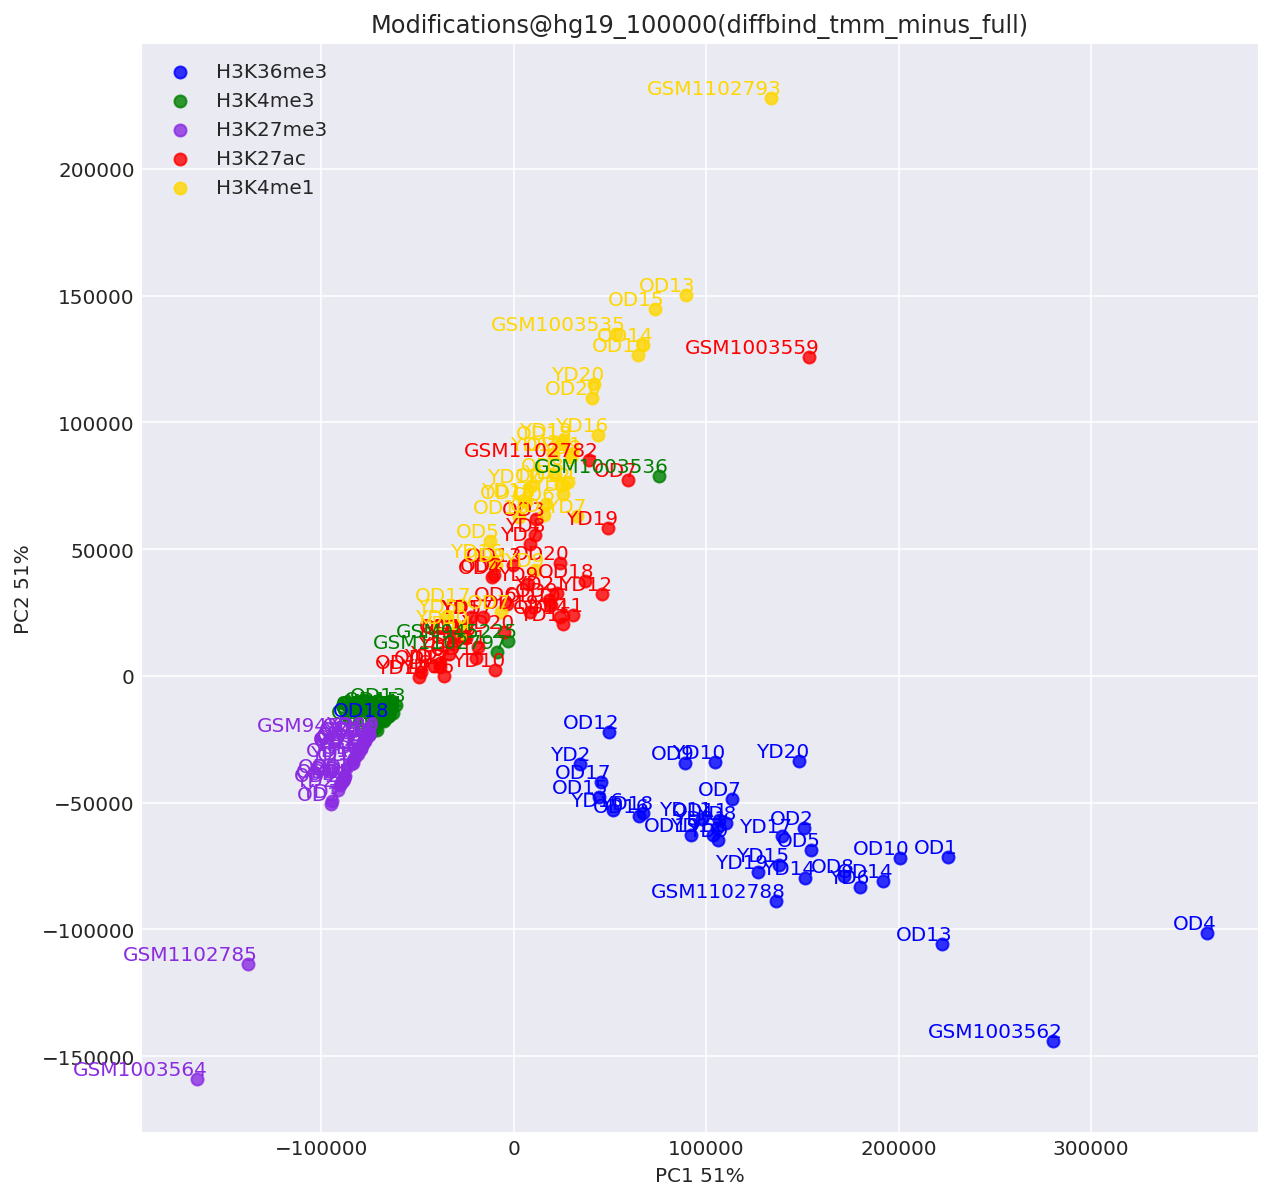

Processing diffbind_tmm_reads_full_cpm at hg19_100000


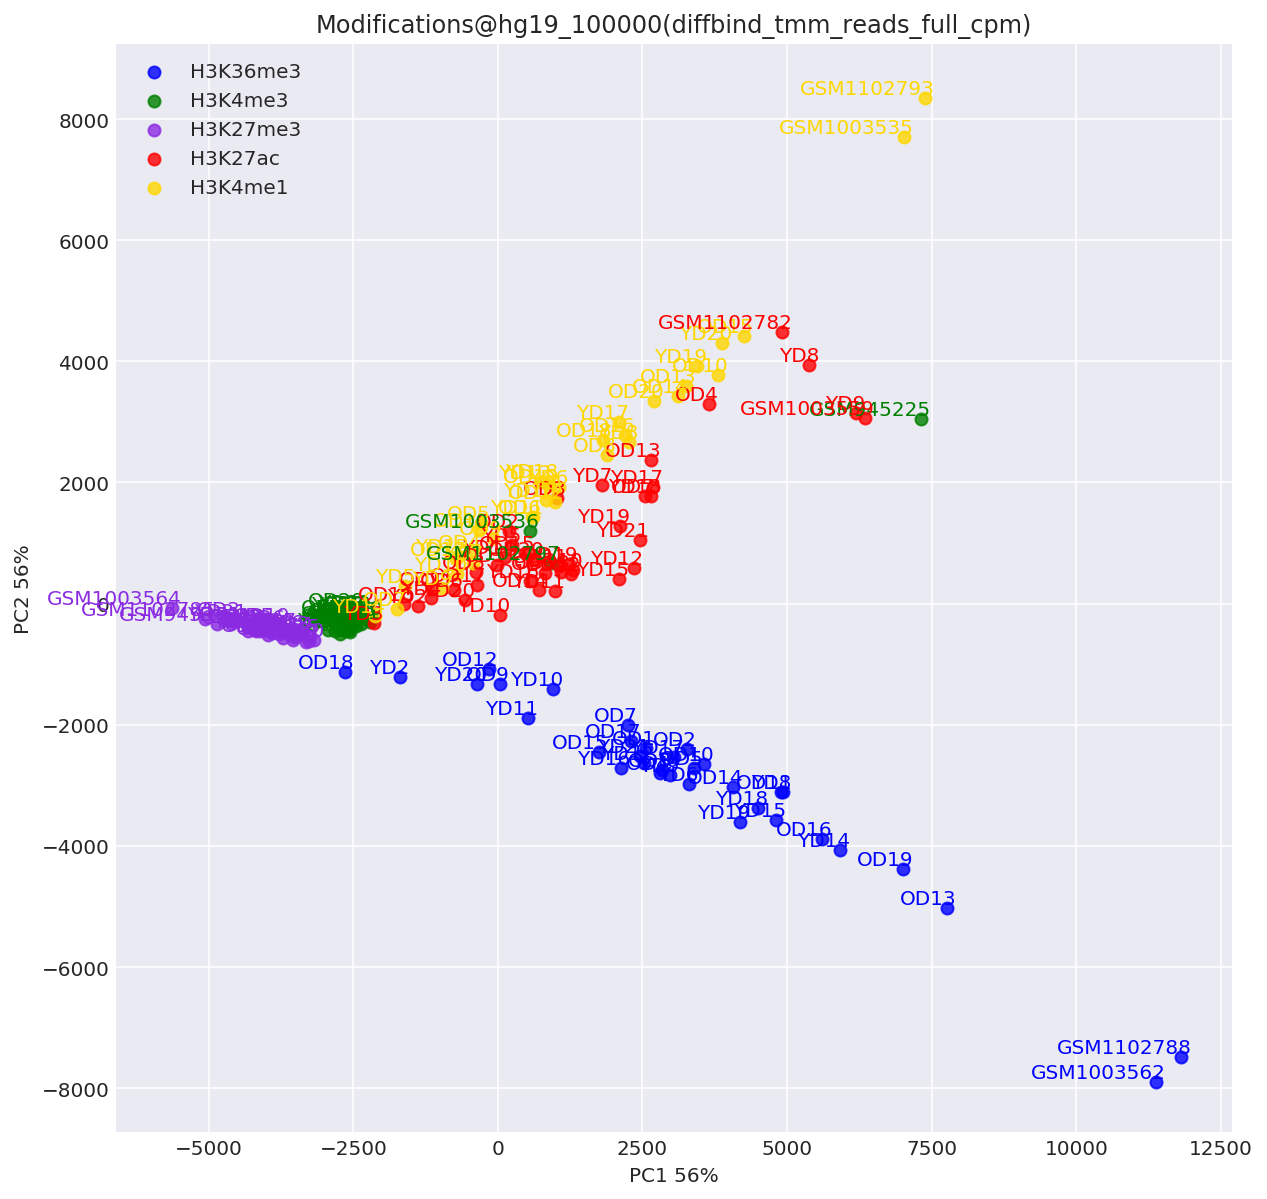

Processing diffbind_tmm_reads_effective_cpm at hg19_100000


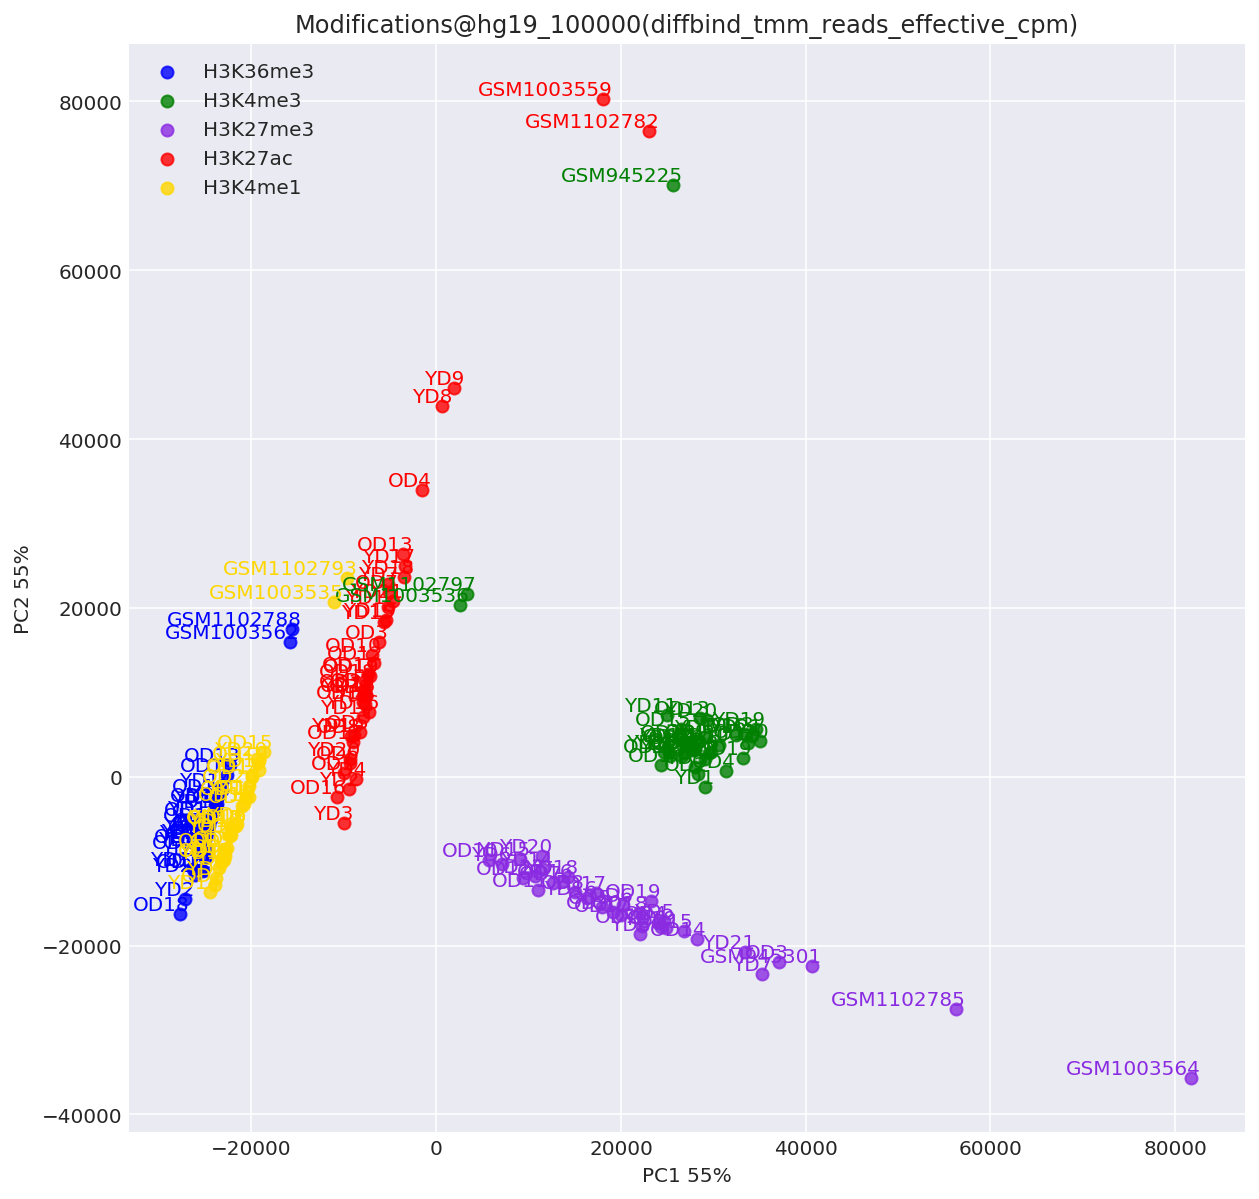

Processing raw at hg19_1000


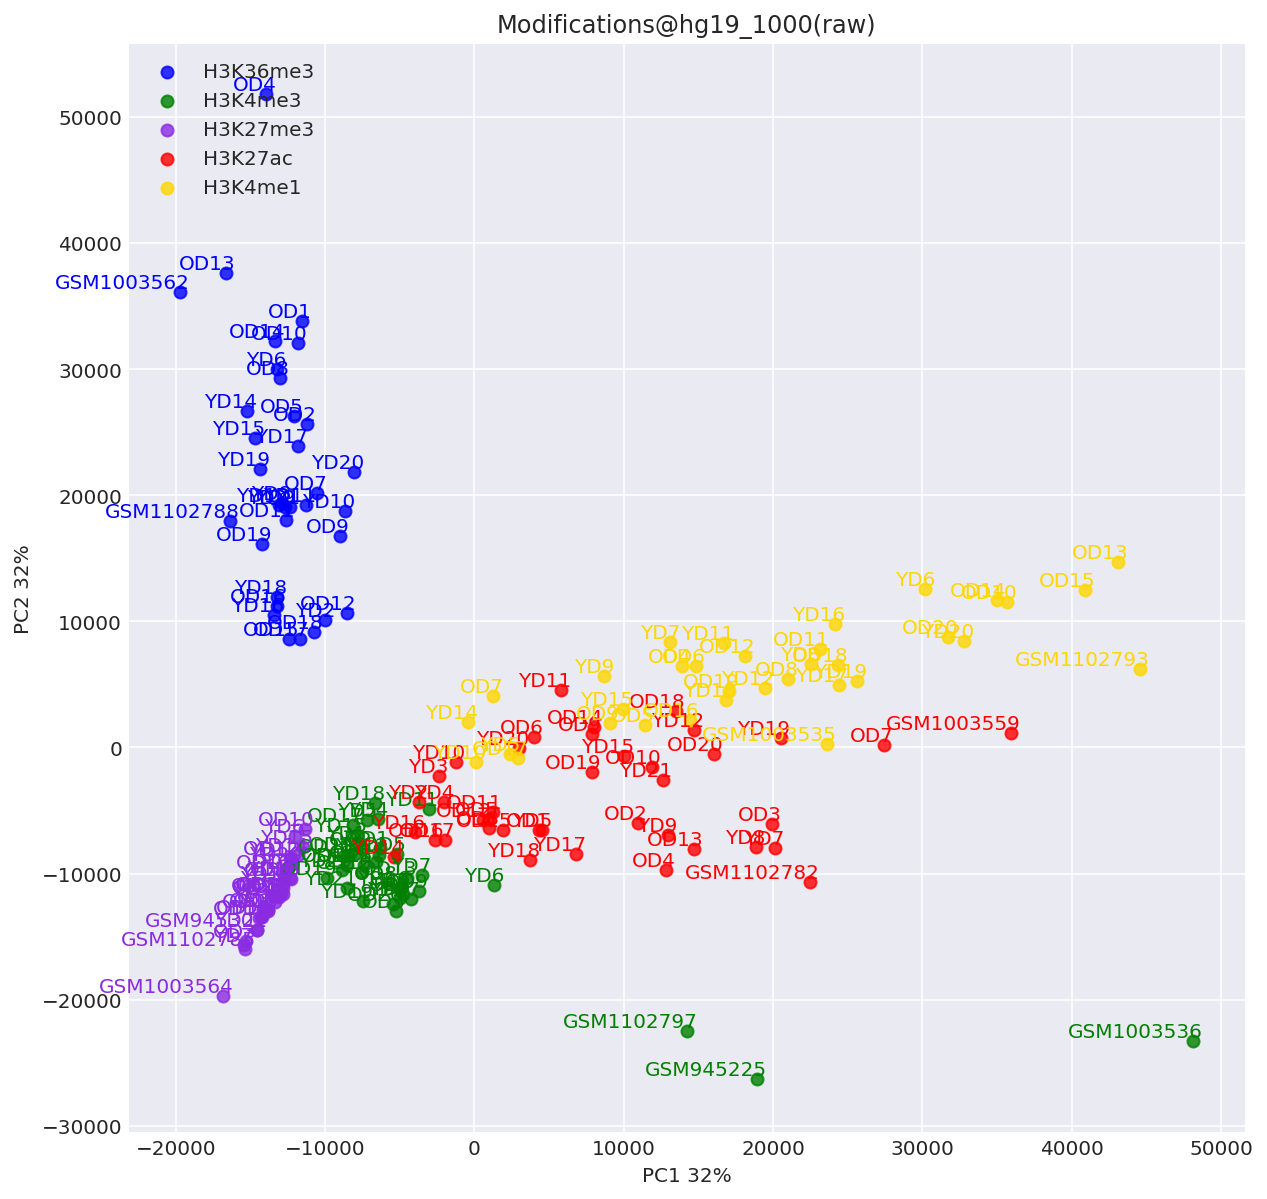

Processing rawz at hg19_1000


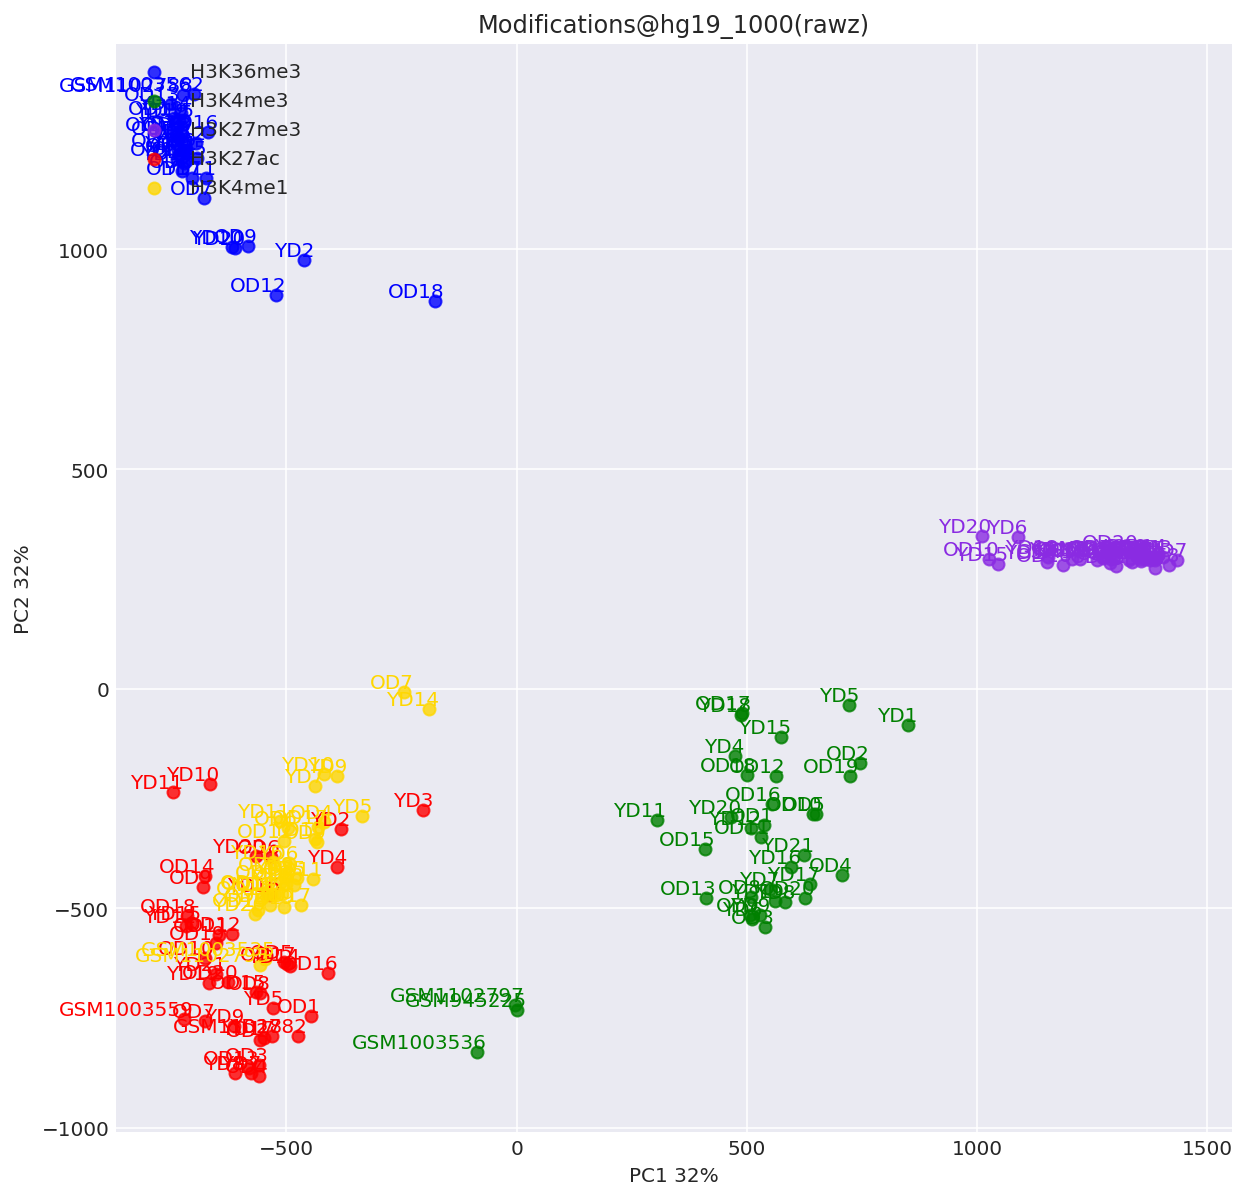

Processing rpm at hg19_1000


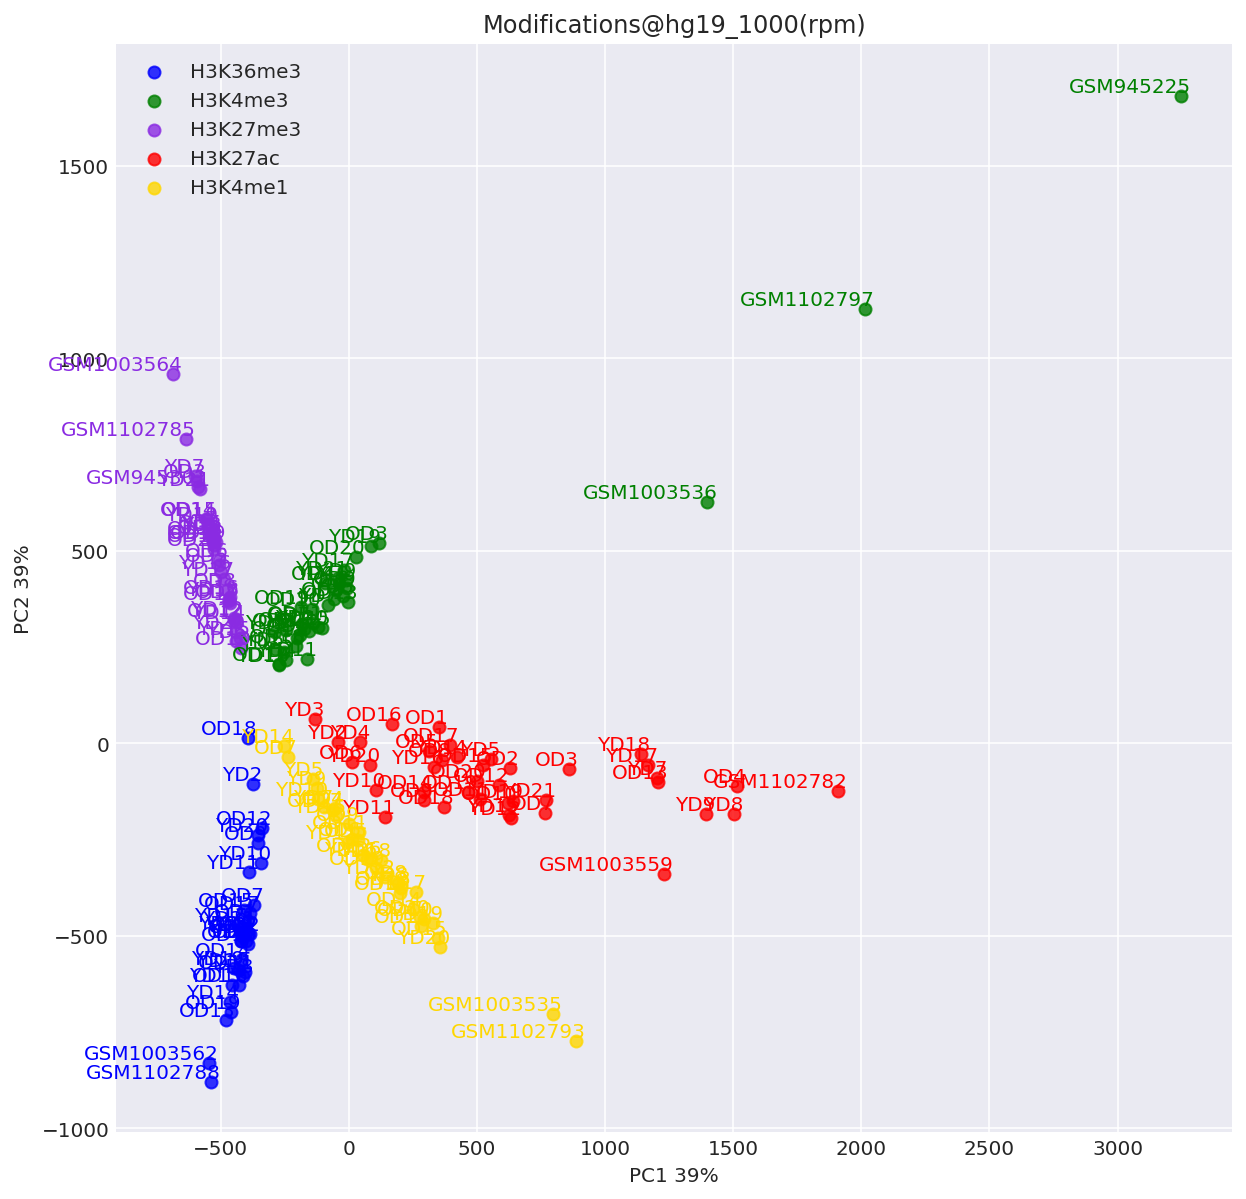

Processing rpkm at hg19_1000


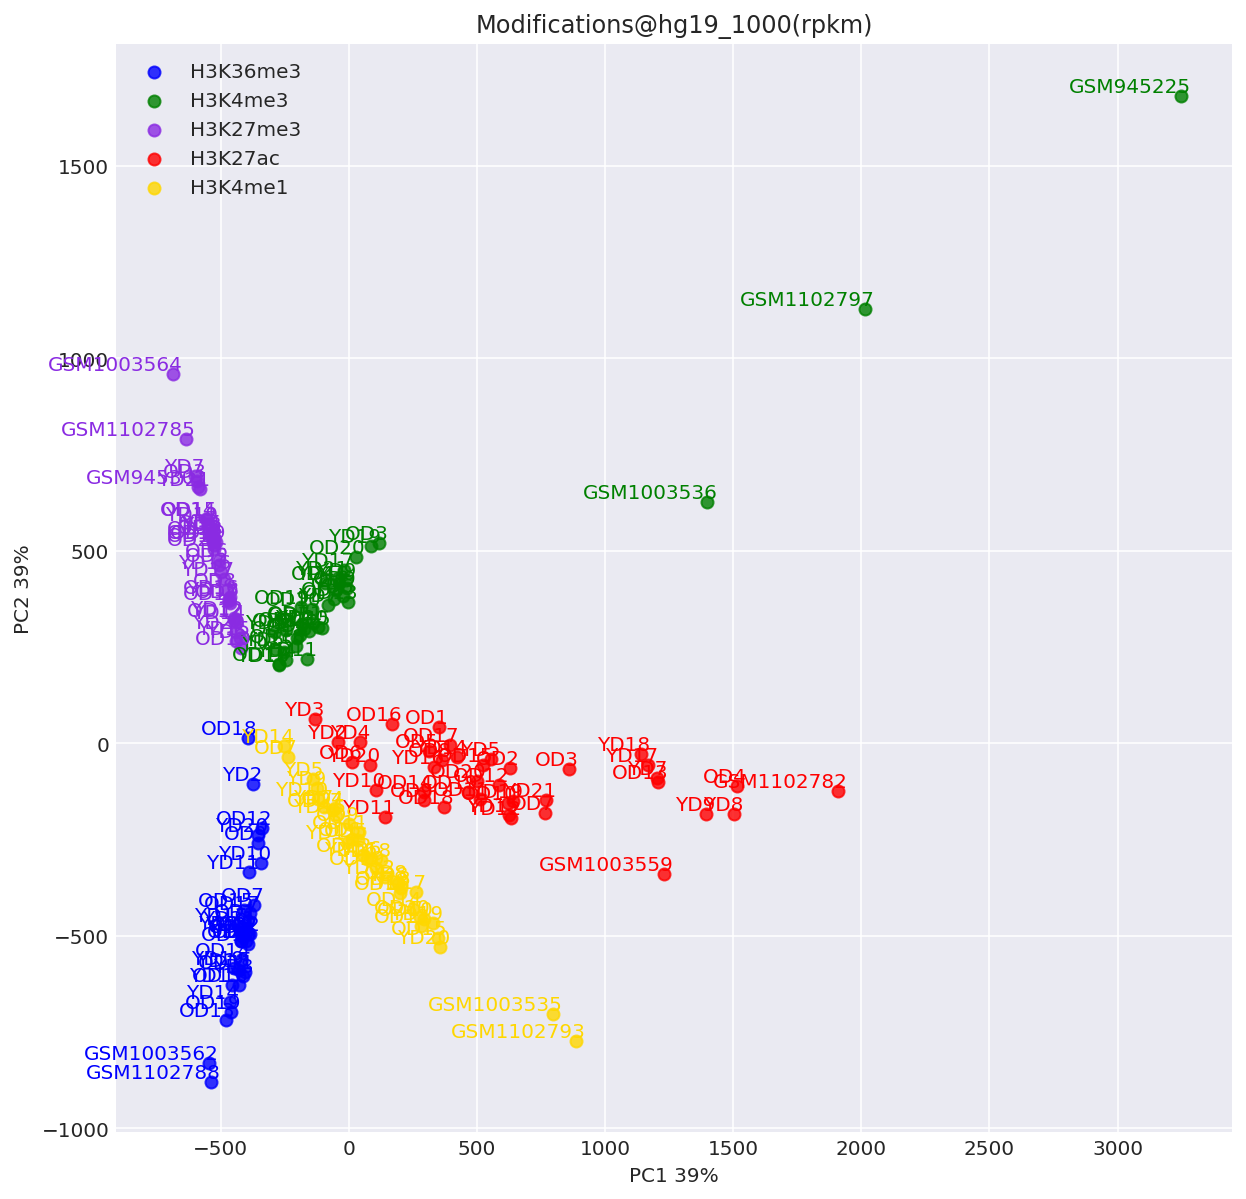

Processing fripm at hg19_1000


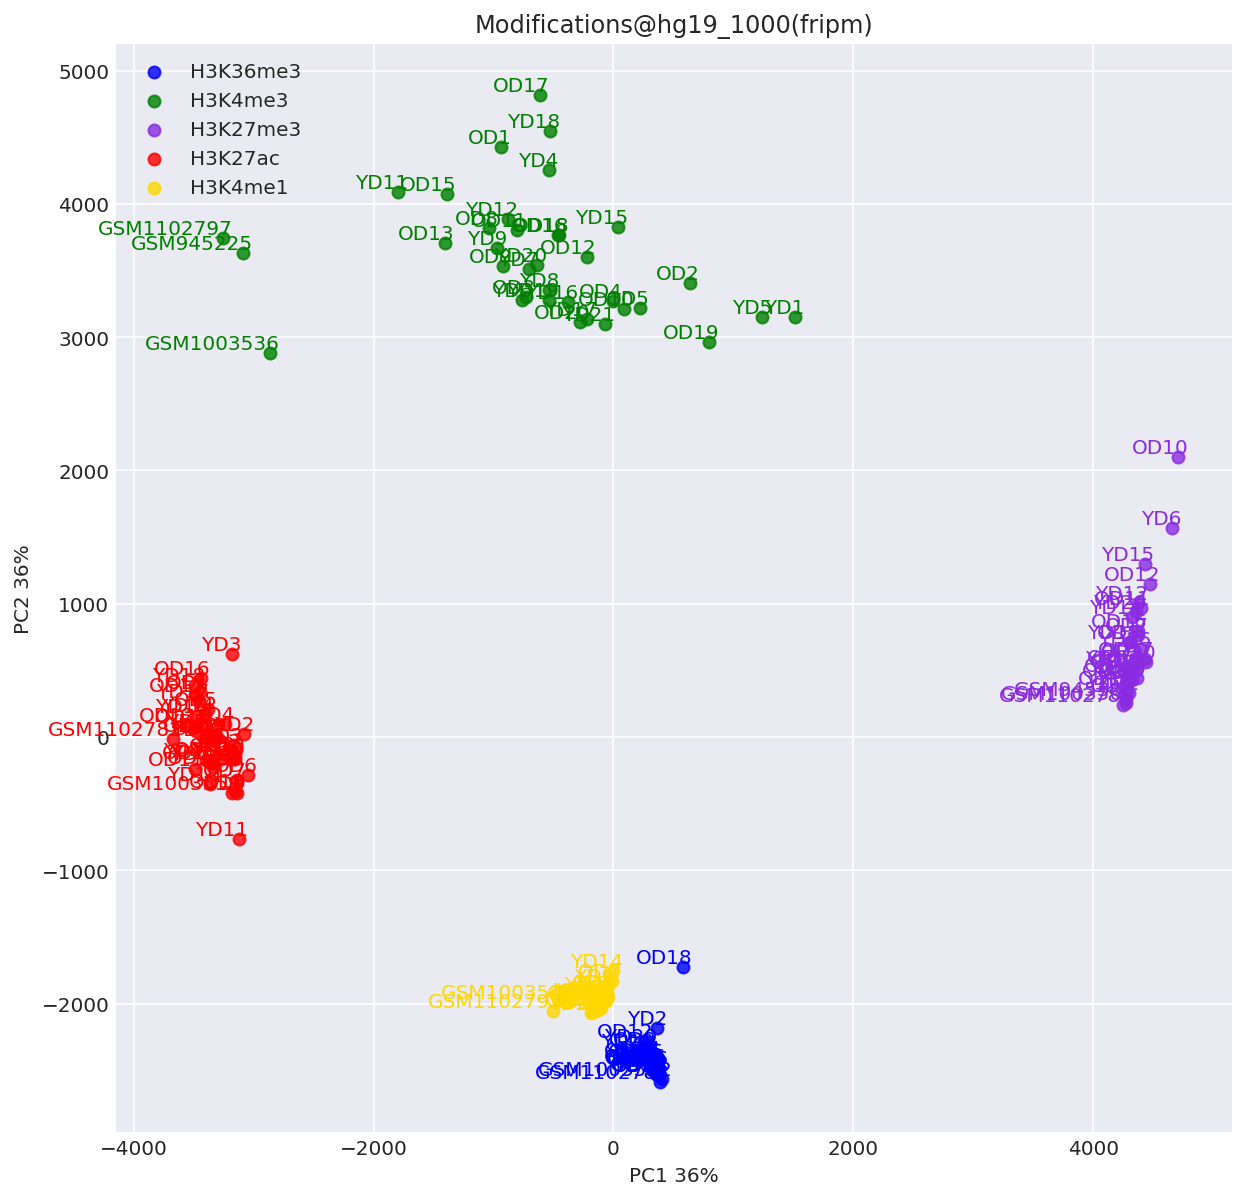

Processing manorm at hg19_1000


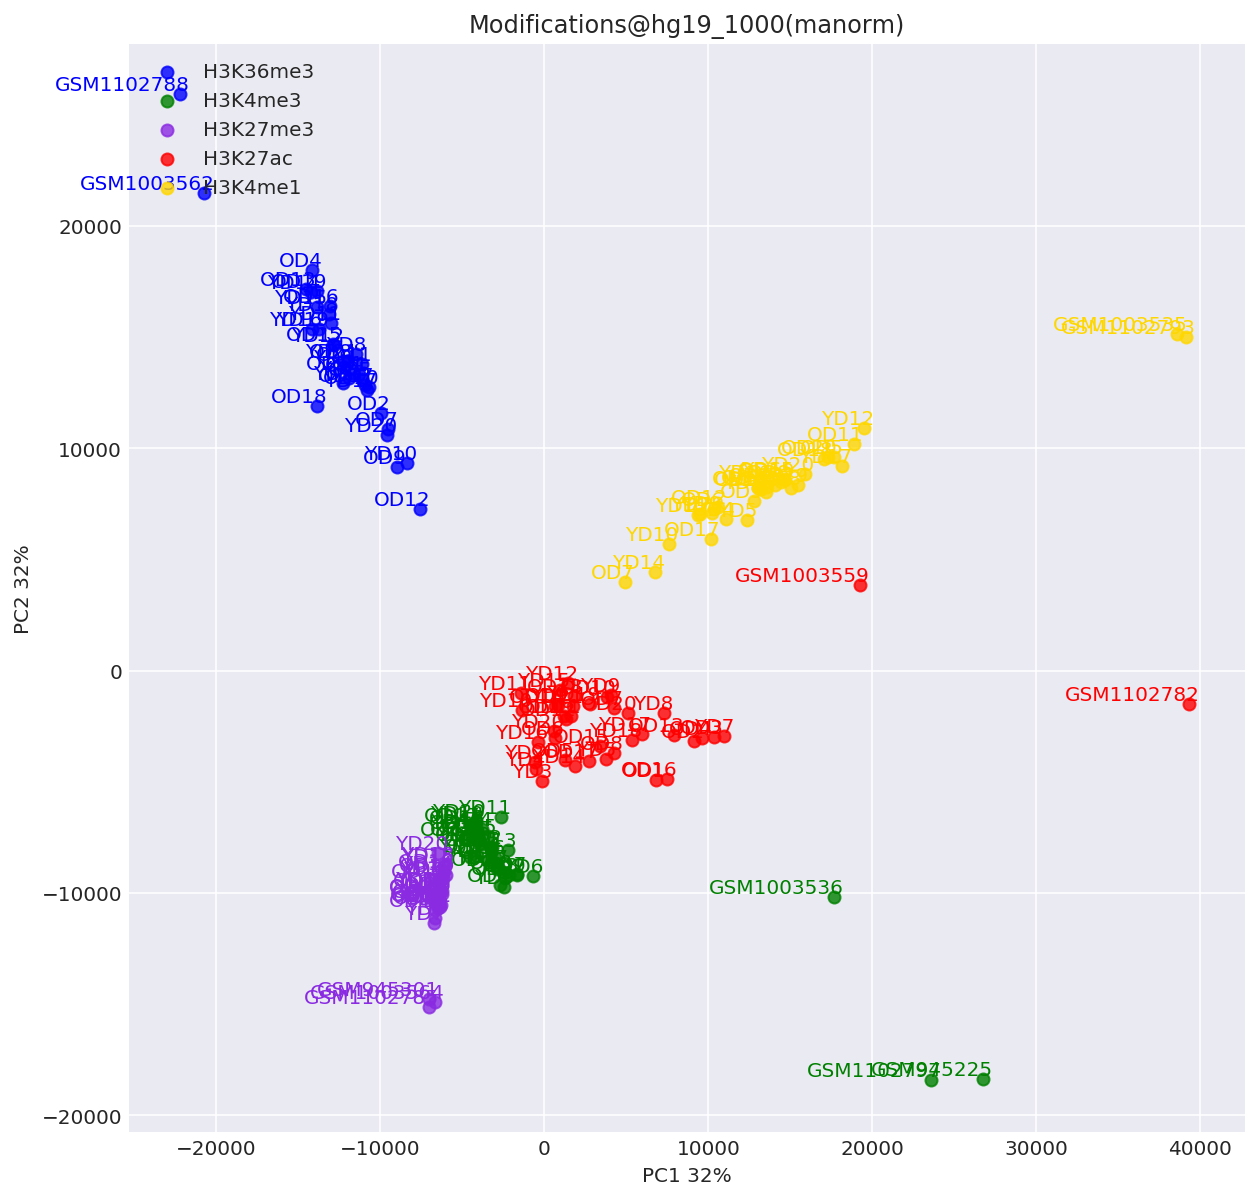

Processing diffbind_tmm_minus_full at hg19_1000


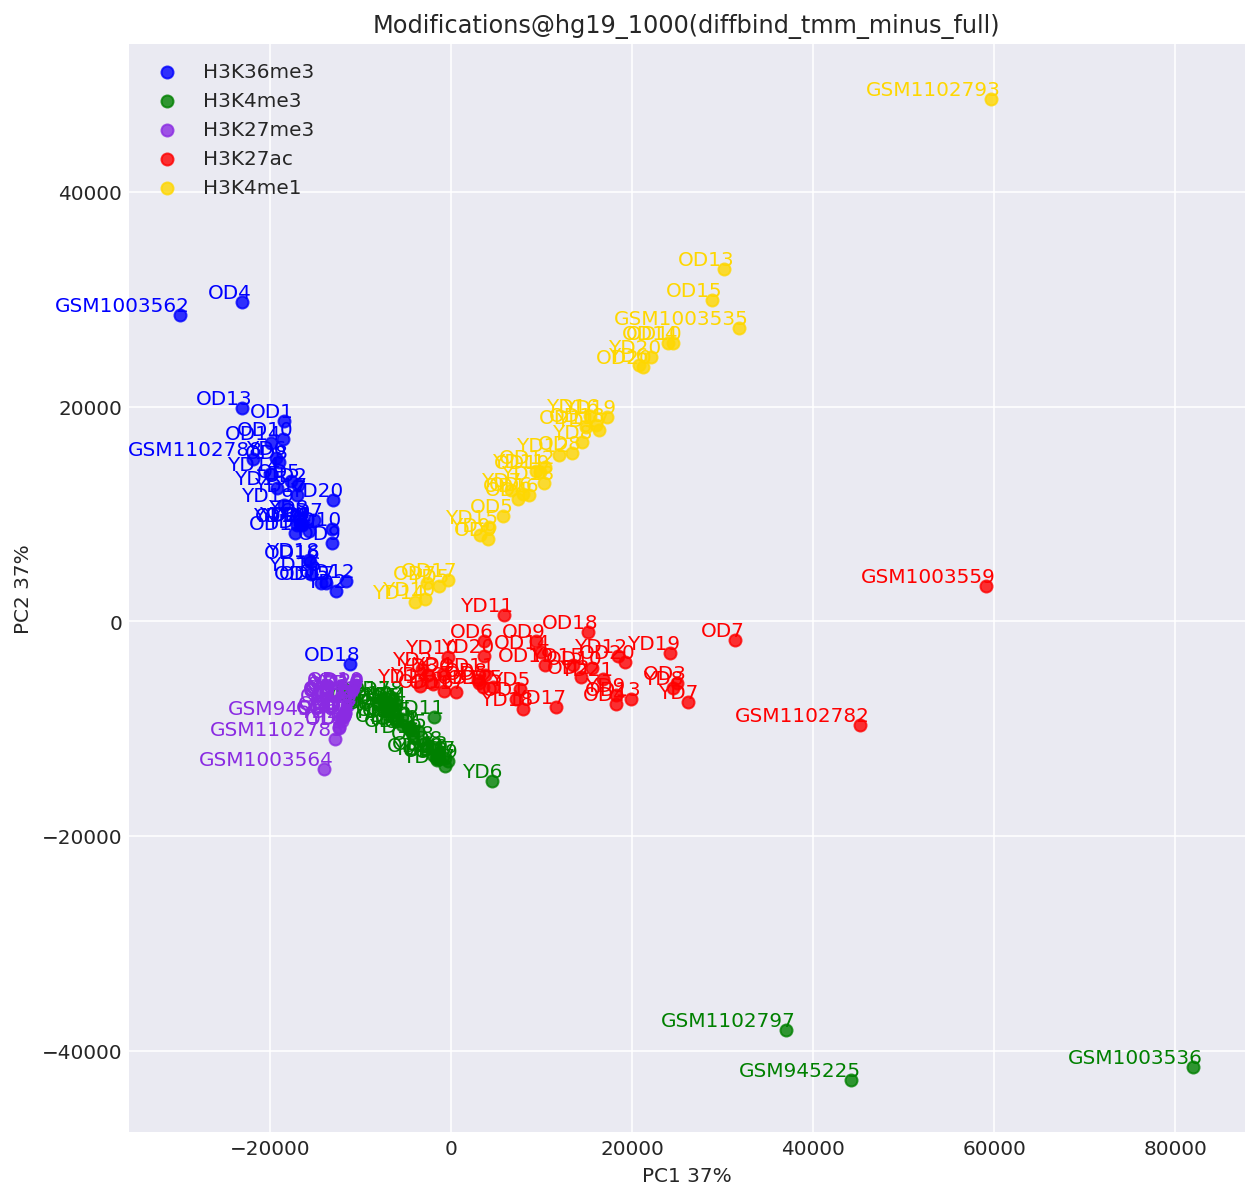

Processing diffbind_tmm_reads_full_cpm at hg19_1000


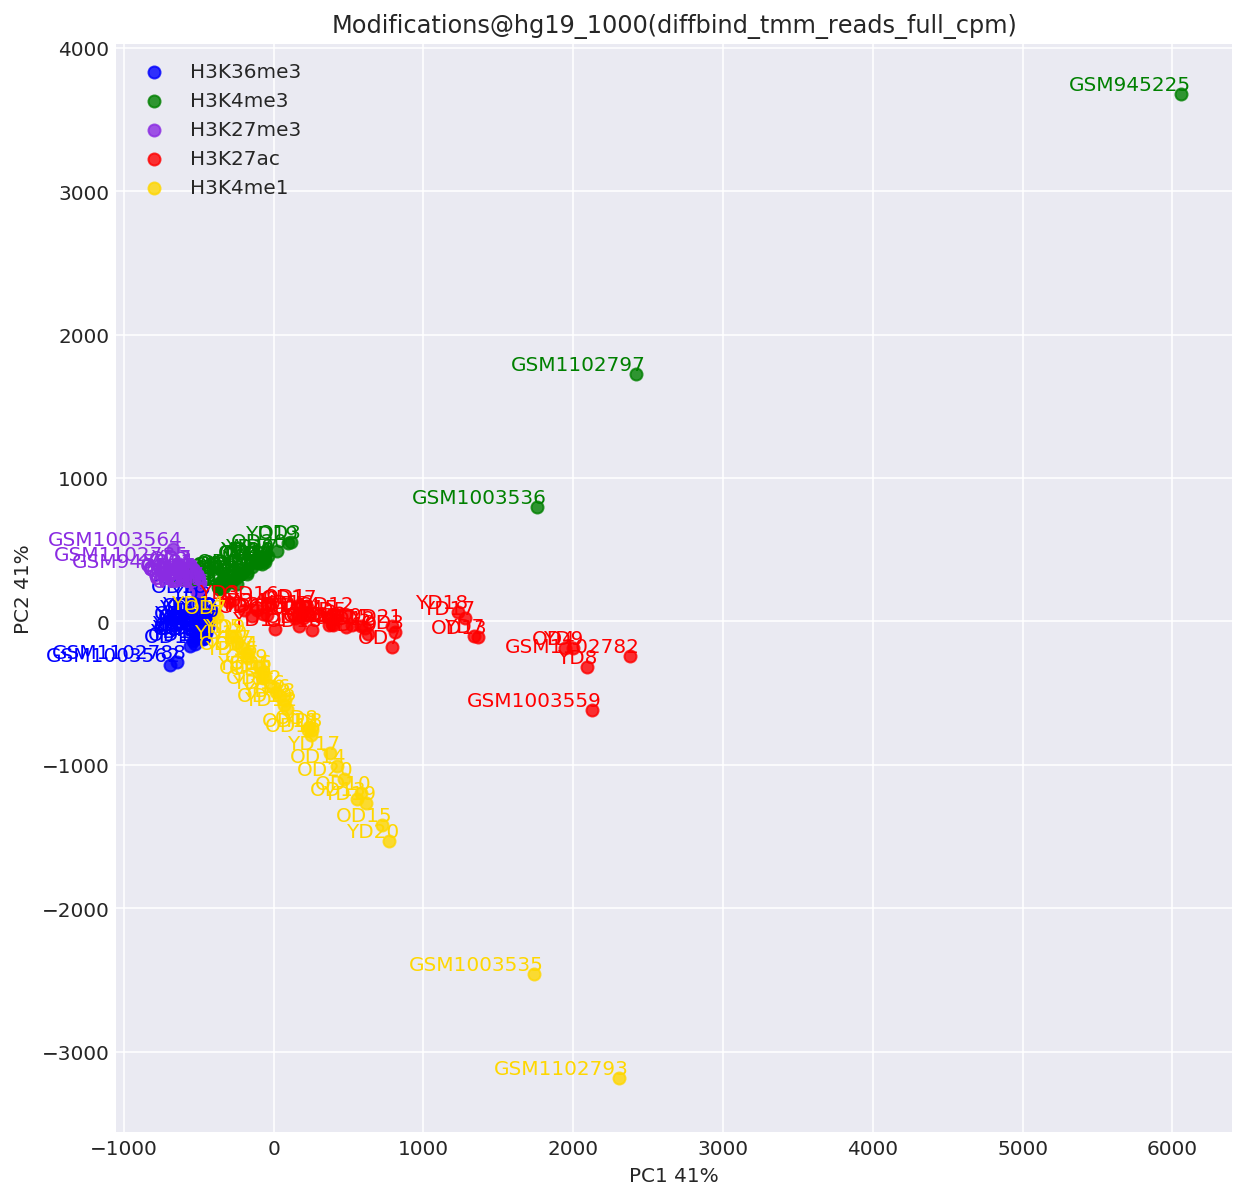

Processing diffbind_tmm_reads_effective_cpm at hg19_1000


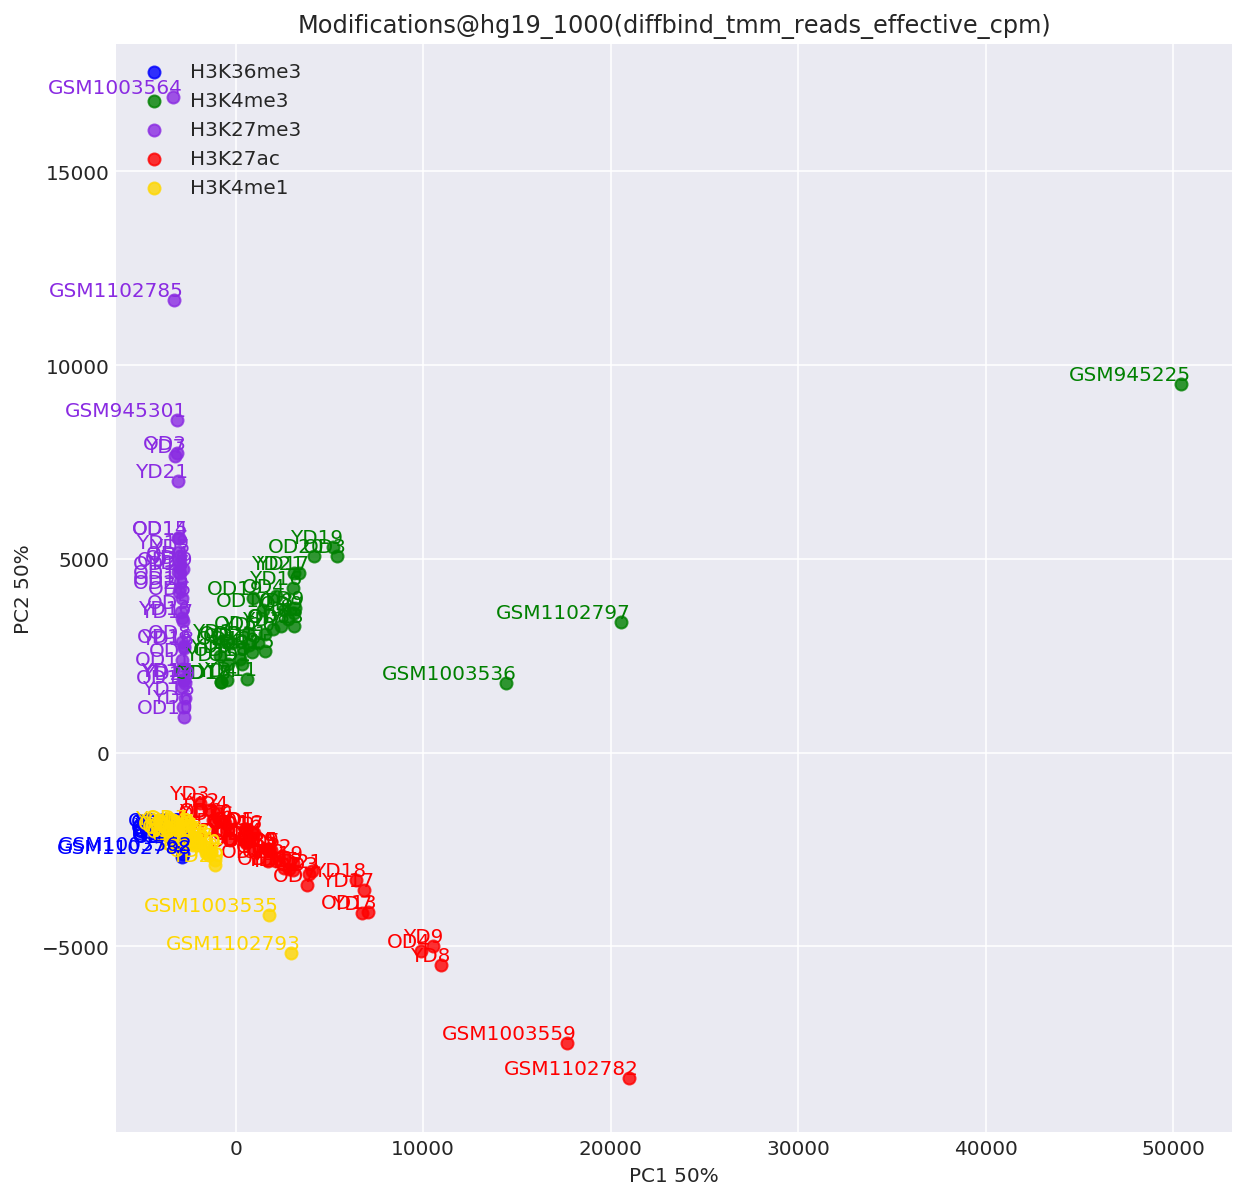

In [2]:
for region in REGIONS:
    for normalization in NORMALIZATIONS:
        try:        
            signal = pd.concat(load_dfs(region, normalization), axis=1)    
            groups = [find_group(r) for r in signal.columns]
            plt.figure(figsize=(10, 10))
            signal_pca_plot(signal, 'Modifications@{}({})'.format(region, normalization),
                            ax=plt.subplot(1, 1, 1), groups=groups)
            plt.legend(loc='upper left')
            plt.show()
        except Exception as e:
            print('Failed to build PCA', e)

# Fripm more PCA

In [8]:
dfs = []
region = 'hg19_1000'
normalization = 'fripm'
signal = pd.concat(load_dfs(region, normalization), axis=1)    
groups = [find_group(r) for r in signal.columns]

columns = signal.columns
if groups is None:
    groups = [group(d) for d in columns]
pca = PCA(n_components=3)
x_r = pca.fit_transform(signal.T)
pca

Processing fripm at hg19_1000


PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
pca = PCA(n_components=3)
pca.fit(Y)
pca_score = pca.explained_variance_ratio_
V = pca.components_

x_pca_axis, y_pca_axis, z_pca_axis = V.T * pca_score / pca_score.min()

x_pca_axis, y_pca_axis, z_pca_axis = 3 * V.T
x_pca_plane = np.r_[x_pca_axis[:2], - x_pca_axis[1::-1]]
y_pca_plane = np.r_[y_pca_axis[:2], - y_pca_axis[1::-1]]
z_pca_plane = np.r_[z_pca_axis[:2], - z_pca_axis[1::-1]]
x_pca_plane.shape = (2, 2)
y_pca_plane.shape = (2, 2)
z_pca_plane.shape = (2, 2)
ax.plot_surface(x_pca_plane, y_pca_plane, z_pca_plane)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])


elev = -40
azim = -80
plot_figs(1, elev, azim)

elev = 30
azim = 20
plot_figs(2, elev, azim)

plt.show()

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

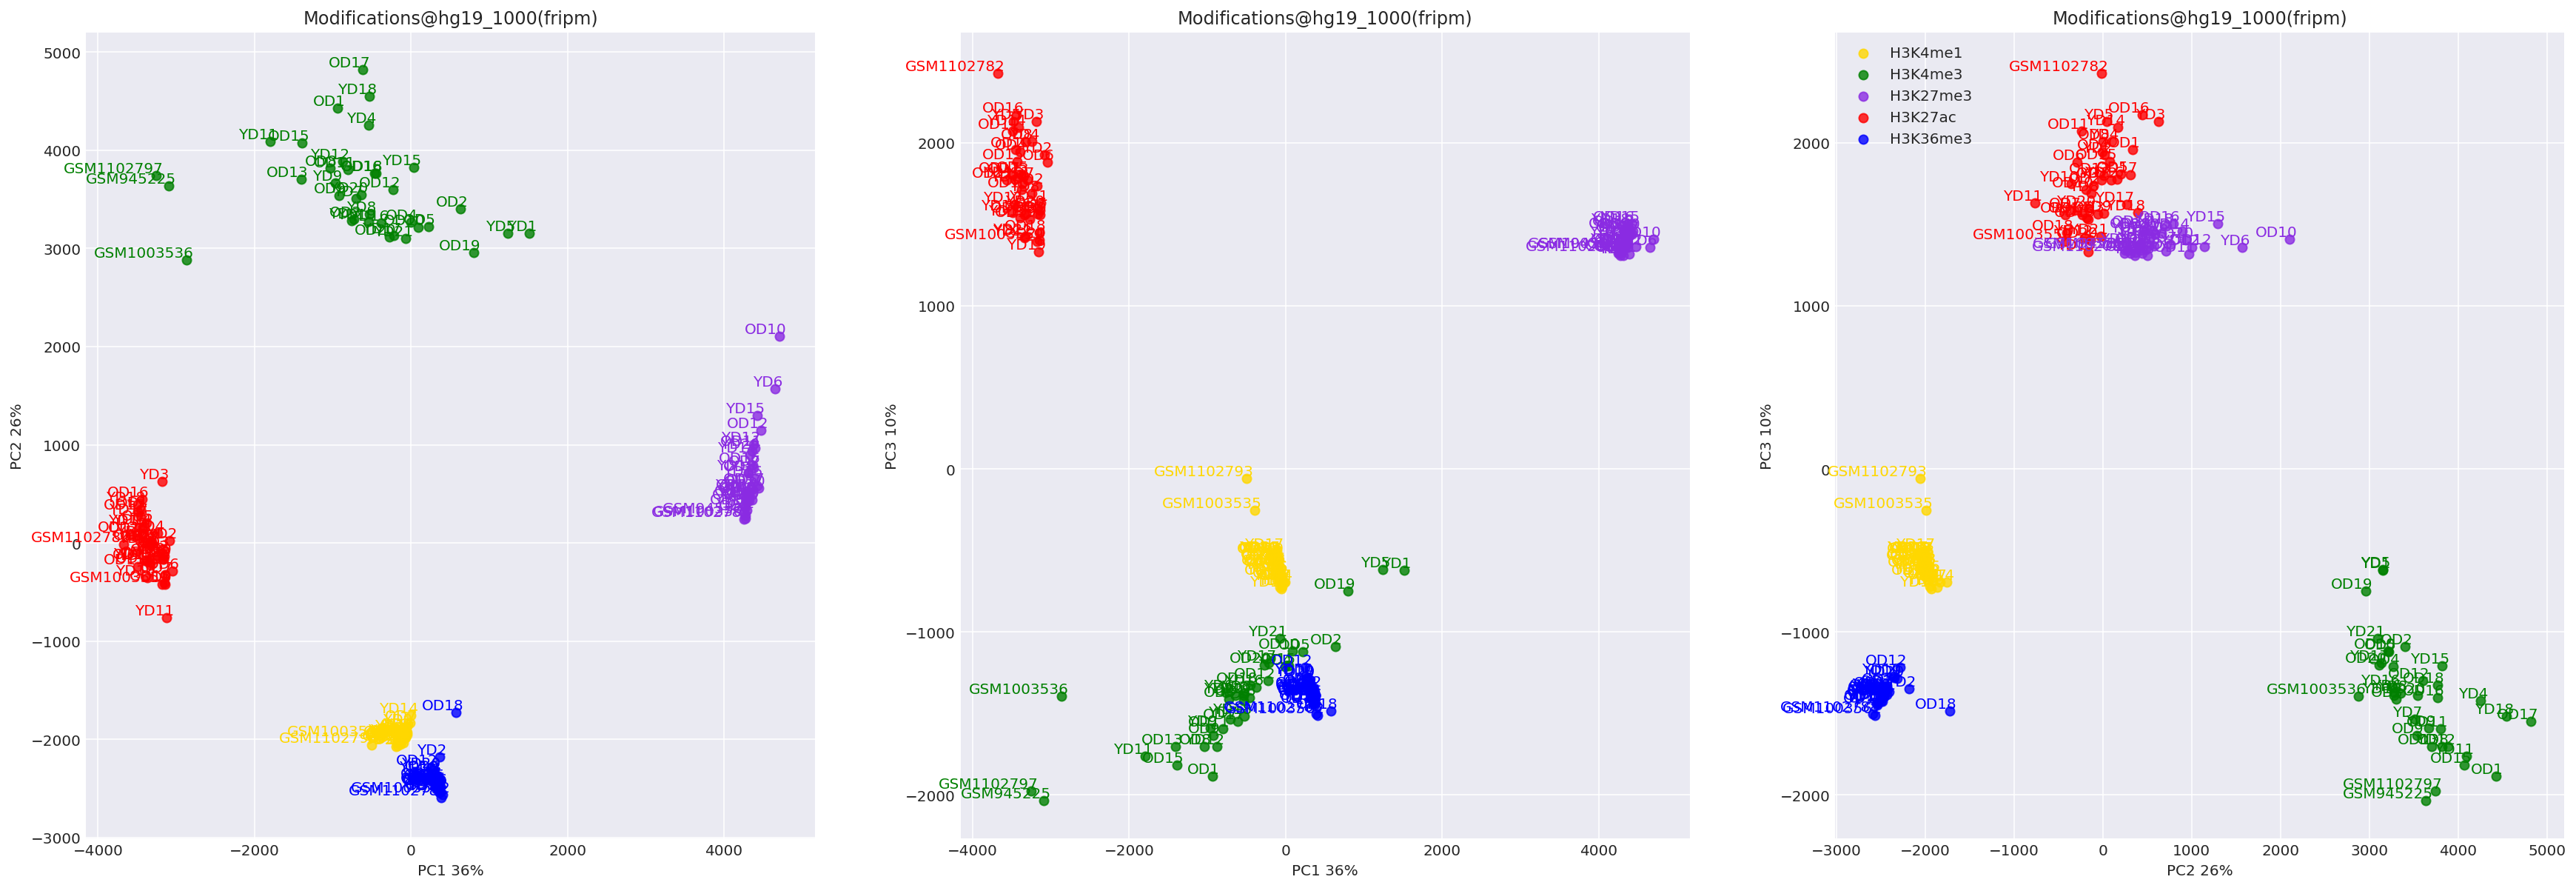

In [15]:
title = 'Modifications@{}({})'.format(region, normalization)
plt.figure(figsize=(30, 10))

pairs = [(0,1), (0,2), (1, 2)]
for i, pair in enumerate(pairs):
    ax = plt.subplot(1, 3, i + 1)
    c1, c2 = pair
    for g in set(groups):
        group_filter = np.asarray([g == n for n in groups])
        ax.scatter(x_r[group_filter, c1], x_r[group_filter, c2],
                   color=g.color, alpha=.8, label=g.name)

    for c, g, x, y in zip(columns, groups, x_r[:, c1], x_r[:, c2]):
        ax.annotate(donor(c),
                    xy=(x, y),
                    xytext=(5, 0),
                    color=g.color,
                    textcoords='offset points',
                    ha='right', va='bottom')
    vars3 = pca.explained_variance_ratio_
    varc1 = vars3[c1]
    varc2 = vars3[c2]
    varc1 = 0.0 if math.isnan(varc1) else int(varc1 * 100)
    varc2 = 0.0 if math.isnan(varc2) else int(varc2 * 100)
    ax.set_xlabel('PC{} {}%'.format(c1 + 1, varc1))
    ax.set_ylabel('PC{} {}%'.format(c2 + 1, varc2))
    ax.set_title(title)
plt.legend(loc='upper left')
plt.show()